<a href="https://colab.research.google.com/github/istiaqahmedfahim/EV-charging-schedule/blob/master/EV_Charging_Pattern_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import uuid
from typing import Dict, List, Tuple
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

class EVChargingDataGenerator:
    def __init__(self, num_records: int = 5000):
        self.num_records = num_records
        self.data = {}

        # Vehicle model specifications (real-world data inspired)
        self.vehicle_models = {
            'Tesla Model 3 LR': {'capacity_range': (75, 82), 'charger_compatibility': ['AC_L2', 'DC_CCS', 'Tesla_SC'],
                                'launch_year': 2017, 'market_share': 0.18},
            'Tesla Model Y': {'capacity_range': (75, 82), 'charger_compatibility': ['AC_L2', 'DC_CCS', 'Tesla_SC'],
                             'launch_year': 2020, 'market_share': 0.16},
            'Nissan Leaf': {'capacity_range': (40, 62), 'charger_compatibility': ['AC_L1', 'AC_L2', 'DC_CHAdeMO'],
                           'launch_year': 2010, 'market_share': 0.12},
            'Chevy Bolt': {'capacity_range': (60, 66), 'charger_compatibility': ['AC_L2', 'DC_CCS'],
                          'launch_year': 2016, 'market_share': 0.09},
            'Ford Mustang Mach-E': {'capacity_range': (70, 91), 'charger_compatibility': ['AC_L2', 'DC_CCS'],
                                   'launch_year': 2020, 'market_share': 0.08},
            'Hyundai Kona Electric': {'capacity_range': (64, 67), 'charger_compatibility': ['AC_L2', 'DC_CCS'],
                                     'launch_year': 2018, 'market_share': 0.07},
            'Volkswagen ID.4': {'capacity_range': (77, 82), 'charger_compatibility': ['AC_L2', 'DC_CCS'],
                               'launch_year': 2020, 'market_share': 0.06},
            'Audi e-tron': {'capacity_range': (86, 95), 'charger_compatibility': ['AC_L2', 'DC_CCS'],
                           'launch_year': 2018, 'market_share': 0.04},
            'Rivian R1T': {'capacity_range': (105, 135), 'charger_compatibility': ['AC_L2', 'DC_CCS'],
                          'launch_year': 2021, 'market_share': 0.03},
            'Porsche Taycan': {'capacity_range': (79, 93), 'charger_compatibility': ['AC_L2', 'DC_CCS'],
                              'launch_year': 2019, 'market_share': 0.02},
            'BMW i3': {'capacity_range': (42, 42), 'charger_compatibility': ['AC_L2', 'DC_CCS'],
                      'launch_year': 2013, 'market_share': 0.05},
            'Kia Niro EV': {'capacity_range': (64, 64), 'charger_compatibility': ['AC_L2', 'DC_CCS'],
                           'launch_year': 2018, 'market_share': 0.06},
            'Tesla Model S': {'capacity_range': (95, 100), 'charger_compatibility': ['AC_L2', 'DC_CCS', 'Tesla_SC'],
                             'launch_year': 2012, 'market_share': 0.04},
        }

        # Charger specifications
        self.charger_types = {
            'AC_L1': {'power_kw': 1.8, 'efficiency': 0.95, 'location_bias': ['workplace', 'residential']},
            'AC_L2': {'power_kw': 7.2, 'efficiency': 0.94, 'location_bias': ['workplace', 'mall', 'public', 'residential']},
            'DC_CCS': {'power_kw': 50.0, 'efficiency': 0.90, 'location_bias': ['highway', 'public']},
            'DC_CHAdeMO': {'power_kw': 50.0, 'efficiency': 0.90, 'location_bias': ['public']},
            'Tesla_SC': {'power_kw': 150.0, 'efficiency': 0.88, 'location_bias': ['highway', 'urban_center']}
        }

        # Time patterns (weighted probabilities for different times)
        self.time_patterns = {
            'weekday': {
                'Morning (6-12)': 0.25,
                'Afternoon (12-17)': 0.30,
                'Evening (17-21)': 0.35,
                'Night (21-6)': 0.10
            },
            'weekend': {
                'Morning (6-12)': 0.20,
                'Afternoon (12-17)': 0.45,
                'Evening (17-21)': 0.25,
                'Night (21-6)': 0.10
            }
        }

        # User base (some users will repeat)
        self.user_base = [str(uuid.uuid4())[:12] for _ in range(500)]

    def generate_user_ids(self):
        """Generate user IDs with repeat patterns (80% of sessions from 40% of users)"""
        # Create skewed distribution
        heavy_users = self.user_base[:200]  # First 200 users are heavy users
        occasional_users = self.user_base[200:]

        # 80% of sessions from heavy users
        heavy_user_sessions = int(self.num_records * 0.8)
        occasional_user_sessions = self.num_records - heavy_user_sessions

        heavy_user_ids = np.random.choice(heavy_users, heavy_user_sessions, replace=True)
        occasional_user_ids = np.random.choice(occasional_users, occasional_user_sessions, replace=True)

        all_user_ids = np.concatenate([heavy_user_ids, occasional_user_ids])
        np.random.shuffle(all_user_ids)

        self.data['User ID'] = all_user_ids

    def generate_vehicle_models(self):
        """Generate vehicle models based on market share"""
        models = list(self.vehicle_models.keys())
        market_shares = [self.vehicle_models[m]['market_share'] for m in models]

        # Normalize to sum to 1
        total = sum(market_shares)
        probabilities = [s/total for s in market_shares]

        self.data['Vehicle Model'] = np.random.choice(models, self.num_records, p=probabilities)

    def generate_battery_capacity(self):
        """Generate battery capacity based on vehicle model"""
        capacities = []
        for model in self.data['Vehicle Model']:
            cap_range = self.vehicle_models[model]['capacity_range']
            # Add ±5% randomness
            base_capacity = np.random.uniform(cap_range[0], cap_range[1])
            randomness = np.random.uniform(0.95, 1.05)
            capacities.append(round(base_capacity * randomness, 1))

        self.data['Battery Capacity (kWh)'] = capacities

    def generate_charging_times(self):
        """Generate realistic charging start and end times"""
        start_times = []
        end_times = []

        # Base date for data generation
        base_date = datetime(2023, 1, 1)

        for _ in range(self.num_records):
            # Random day within 365 days
            day_offset = np.random.randint(0, 365)
            current_date = base_date + timedelta(days=day_offset)

            # Determine if weekday or weekend
            is_weekend = current_date.weekday() >= 5

            # Choose time of day based on patterns
            if is_weekend:
                time_slot = np.random.choice(
                    list(self.time_patterns['weekend'].keys()),
                    p=list(self.time_patterns['weekend'].values())
                )
            else:
                time_slot = np.random.choice(
                    list(self.time_patterns['weekday'].keys()),
                    p=list(self.time_patterns['weekday'].values())
                )

            # Generate random time within the slot
            if time_slot == 'Morning (6-12)':
                hour = np.random.randint(6, 12)
            elif time_slot == 'Afternoon (12-17)':
                hour = np.random.randint(12, 17)
            elif time_slot == 'Evening (17-21)':
                hour = np.random.randint(17, 21)
            else:  # Night (21-6)
                hour = np.random.choice(list(range(21, 24)) + list(range(0, 6)))

            minute = np.random.randint(0, 60)
            second = np.random.randint(0, 60)

            start_time = current_date.replace(hour=hour, minute=minute, second=second)
            start_times.append(start_time)

        self.data['Charging Start Time'] = start_times

    def generate_charger_types(self):
        """Generate charger types based on vehicle model and time of day"""
        charger_types = []

        for i in range(self.num_records):
            model = self.data['Vehicle Model'][i]
            start_time = self.data['Charging Start Time'][i]
            hour = start_time.hour

            compatible_chargers = self.vehicle_models[model]['charger_compatibility']

            # Time-based charger probability adjustments
            charger_probs = {}

            for charger in compatible_chargers:
                base_prob = 1.0

                # Adjust probabilities based on time
                if charger in ['DC_CCS', 'Tesla_SC', 'DC_CHAdeMO']:
                    if 6 <= hour <= 9:  # Morning commute
                        base_prob *= 1.3
                    elif 17 <= hour <= 19:  # Evening commute
                        base_prob *= 1.5
                    elif 0 <= hour <= 6:  # Night
                        base_prob *= 0.3
                elif charger == 'AC_L2':
                    if 9 <= hour <= 17:  # Workplace charging
                        base_prob *= 2.0
                    elif 0 <= hour <= 6:  # Overnight
                        base_prob *= 1.5

                charger_probs[charger] = base_prob

            # Normalize probabilities
            total = sum(charger_probs.values())
            charger_probs = {k: v/total for k, v in charger_probs.items()}

            # Select charger
            chargers = list(charger_probs.keys())
            probs = list(charger_probs.values())
            charger_types.append(np.random.choice(chargers, p=probs))

        self.data['Charger Type'] = charger_types

    def generate_soc_levels(self):
        """Generate realistic State of Charge levels"""
        soc_starts = []
        soc_ends = []

        for i in range(self.num_records):
            charger_type = self.data['Charger Type'][i]

            # Different SOC behaviors based on charger type
            if charger_type in ['DC_CCS', 'Tesla_SC', 'DC_CHAdeMO']:  # Fast charging
                # Fast charging often starts with low SOC
                soc_start = np.random.triangular(10, 25, 40)  # Most likely around 25%

                # Fast charging often stops at 80% due to taper
                if np.random.random() < 0.7:
                    soc_end = np.random.triangular(75, 80, 85)
                else:
                    soc_end = np.random.triangular(85, 95, 100)

            else:  # Slow charging (AC)
                # AC charging can start with various SOC levels
                soc_start = np.random.triangular(20, 50, 80)

                # AC charging often goes to full or near-full
                if np.random.random() < 0.6:
                    soc_end = np.random.triangular(90, 98, 100)
                else:
                    soc_end = np.random.triangular(80, 90, 95)

            # Add some noise (±2%)
            soc_start += np.random.uniform(-2, 2)
            soc_end += np.random.uniform(-2, 2)

            # Clamp to realistic bounds
            soc_start = max(5, min(95, soc_start))
            soc_end = max(soc_start + 5, min(100, soc_end))  # Must charge at least 5%

            soc_starts.append(round(soc_start, 1))
            soc_ends.append(round(soc_end, 1))

        self.data['State of Charge (Start %)'] = soc_starts
        self.data['State of Charge (End %)'] = soc_ends

    def generate_temperature(self):
        """Generate realistic temperature based on time of year and day"""
        temperatures = []

        for i in range(self.num_records):
            start_time = self.data['Charging Start Time'][i]
            month = start_time.month
            hour = start_time.hour

            # Base temperature by month (Northern Hemisphere)
            month_temps = {
                1: 5, 2: 6, 3: 10, 4: 15, 5: 20, 6: 25,
                7: 28, 8: 27, 9: 23, 10: 17, 11: 11, 12: 7
            }

            base_temp = month_temps[month]

            # Daily variation (colder at night, warmer in afternoon)
            daily_variation = 8 * np.sin((hour - 6) * np.pi / 12)

            # Add noise
            noise = np.random.uniform(-3, 3)

            temperature = base_temp + daily_variation + noise
            temperatures.append(round(temperature, 1))

        self.data['Temperature (C)'] = temperatures

    def generate_vehicle_age(self):
        """Generate vehicle age based on model launch year"""
        ages = []
        current_year = 2023

        for model in self.data['Vehicle Model']:
            launch_year = self.vehicle_models[model]['launch_year']

            # Base age from launch year
            base_age = current_year - launch_year

            # Add random age (0-3 years) around base
            age_variation = np.random.uniform(0, 3)

            # Vehicles newer than launch year possible (some released later)
            age = max(0, base_age + age_variation)
            ages.append(round(age, 1))

        self.data['Vehicle Age (years)'] = ages

    def calculate_energy_consumed(self):
        """Calculate energy consumed with charging losses"""
        energy_consumed = []

        for i in range(self.num_records):
            battery_capacity = self.data['Battery Capacity (kWh)'][i]
            soc_start = self.data['State of Charge (Start %)'][i]
            soc_end = self.data['State of Charge (End %)'][i]
            charger_type = self.data['Charger Type'][i]

            # Charging efficiency based on charger type
            efficiency = self.charger_types[charger_type]['efficiency']

            # Energy delivered to battery
            battery_energy = battery_capacity * (soc_end - soc_start) / 100

            # Energy from grid (accounting for losses)
            grid_energy = battery_energy / efficiency

            # Add 1-3% noise
            noise = np.random.uniform(0.97, 1.03)
            grid_energy *= noise

            # Cap at realistic maximum (can't charge more than battery capacity + losses)
            max_possible = battery_capacity * 1.2 / efficiency
            grid_energy = min(grid_energy, max_possible)

            energy_consumed.append(round(grid_energy, 2))

        self.data['Energy Consumed (kWh)'] = energy_consumed

    def calculate_charging_duration(self):
        """Calculate charging duration and end time"""
        durations = []
        end_times = []

        for i in range(self.num_records):
            energy = self.data['Energy Consumed (kWh)'][i]
            charger_type = self.data['Charger Type'][i]
            start_time = self.data['Charging Start Time'][i]
            soc_start = self.data['State of Charge (Start %)'][i]
            soc_end = self.data['State of Charge (End %)'][i]

            charger_power = self.charger_types[charger_type]['power_kw']

            # Minimum theoretical duration
            min_duration_hours = energy / charger_power

            # Realistic adjustments
            if charger_type in ['DC_CCS', 'Tesla_SC', 'DC_CHAdeMO']:
                # Fast charging: account for taper at high SOC
                taper_factor = 1.0
                if soc_end > 80:
                    # Charging slows down above 80%
                    taper_factor += 0.3 * ((soc_end - 80) / 20)

                # Add overhead (connecting, authentication, etc.)
                overhead = np.random.uniform(0.08, 0.25)  # 5-15 minutes

                actual_duration = min_duration_hours * taper_factor + overhead

            else:  # AC charging
                # AC charging often lasts longer than needed (car parked)
                parking_factor = np.random.uniform(1.2, 3.0)

                # Minimum practical duration (people don't unplug immediately)
                min_practical = max(min_duration_hours, np.random.uniform(2, 4))

                actual_duration = max(min_duration_hours * parking_factor, min_practical)

            # Add some random variation
            actual_duration *= np.random.uniform(0.95, 1.05)

            # Round to nearest 0.1 hour
            actual_duration = round(actual_duration, 2)

            # Calculate end time
            end_time = start_time + timedelta(hours=actual_duration)

            durations.append(actual_duration)
            end_times.append(end_time)

        self.data['Charging Duration (hours)'] = durations
        self.data['Charging End Time'] = end_times

    def generate_time_of_day(self):
        """Categorize charging start time into time of day"""
        time_of_day = []

        for start_time in self.data['Charging Start Time']:
            hour = start_time.hour

            if 6 <= hour < 12:
                time_of_day.append('Morning')
            elif 12 <= hour < 17:
                time_of_day.append('Afternoon')
            elif 17 <= hour < 21:
                time_of_day.append('Evening')
            else:
                time_of_day.append('Night')

        self.data['Time of Day'] = time_of_day

    def add_data_errors(self):
        """Add realistic data errors (0.5% of records)"""
        num_errors = int(self.num_records * 0.005)
        error_indices = np.random.choice(self.num_records, num_errors, replace=False)

        for idx in error_indices:
            error_type = np.random.choice(['duration', 'energy', 'time', 'soc'])

            if error_type == 'duration':
                # Negative or impossible duration
                self.data['Charging Duration (hours)'][idx] = -abs(np.random.uniform(0.1, 2))
            elif error_type == 'energy':
                # Energy consumption too high
                self.data['Energy Consumed (kWh)'][idx] *= np.random.uniform(1.5, 3)
            elif error_type == 'time':
                # End time before start time
                self.data['Charging End Time'][idx] = self.data['Charging Start Time'][idx] - timedelta(hours=1)
            elif error_type == 'soc':
                # SOC end less than SOC start
                self.data['State of Charge (End %)'][idx] = self.data['State of Charge (Start %)'][idx] - 10

    def generate_dataset(self):
        """Generate complete dataset"""
        print("Step 1: Generating User IDs...")
        self.generate_user_ids()

        print("Step 2: Generating Vehicle Models...")
        self.generate_vehicle_models()

        print("Step 3: Generating Battery Capacity...")
        self.generate_battery_capacity()

        print("Step 4: Generating Charging Start Times...")
        self.generate_charging_times()

        print("Step 5: Generating Charger Types...")
        self.generate_charger_types()

        print("Step 6: Generating SOC Levels...")
        self.generate_soc_levels()

        print("Step 7: Generating Temperature...")
        self.generate_temperature()

        print("Step 8: Generating Vehicle Age...")
        self.generate_vehicle_age()

        print("Step 9: Calculating Energy Consumed...")
        self.calculate_energy_consumed()

        print("Step 10: Calculating Charging Duration and End Time...")
        self.calculate_charging_duration()

        print("Step 11: Generating Time of Day...")
        self.generate_time_of_day()

        print("Step 12: Adding Data Errors...")
        self.add_data_errors()

        # Create DataFrame with correct column order
        columns = [
            'User ID', 'Vehicle Model', 'Battery Capacity (kWh)',
            'Charging Start Time', 'Charging End Time', 'Energy Consumed (kWh)',
            'Charging Duration (hours)', 'Time of Day', 'State of Charge (Start %)',
            'State of Charge (End %)', 'Temperature (C)', 'Vehicle Age (years)',
            'Charger Type'
        ]

        df = pd.DataFrame(self.data, columns=columns)

        print(f"\nDataset generated with {len(df)} records")
        print("\nDataset Summary:")
        print(df.info())

        return df

    def calculate_statistics(self, df):
        """Calculate and display dataset statistics"""
        print("\n=== Dataset Statistics ===")

        # Basic statistics
        print(f"\n1. Record Count: {len(df)}")
        print(f"2. Date Range: {df['Charging Start Time'].min()} to {df['Charging End Time'].max()}")

        # User statistics
        unique_users = df['User ID'].nunique()
        sessions_per_user = df['User ID'].value_counts()
        print(f"\n3. Unique Users: {unique_users}")
        print(f"   Average sessions per user: {len(df)/unique_users:.2f}")
        print(f"   Top 10% users account for {sessions_per_user[:int(len(sessions_per_user)*0.1)].sum()/len(df)*100:.1f}% of sessions")

        # Vehicle model distribution
        print(f"\n4. Top 5 Vehicle Models:")
        model_dist = df['Vehicle Model'].value_counts(normalize=True).head()
        for model, pct in model_dist.items():
            print(f"   {model}: {pct*100:.1f}%")

        # Charger type distribution
        print(f"\n5. Charger Type Distribution:")
        charger_dist = df['Charger Type'].value_counts(normalize=True)
        for charger, pct in charger_dist.items():
            print(f"   {charger}: {pct*100:.1f}%")

        # Time of day patterns
        print(f"\n6. Time of Day Distribution:")
        time_dist = df['Time of Day'].value_counts(normalize=True)
        for tod, pct in time_dist.items():
            print(f"   {tod}: {pct*100:.1f}%")

        # Energy consumption statistics
        print(f"\n7. Energy Consumption Stats:")
        print(f"   Mean: {df['Energy Consumed (kWh)'].mean():.2f} kWh")
        print(f"   Median: {df['Energy Consumed (kWh)'].median():.2f} kWh")
        print(f"   Min: {df['Energy Consumed (kWh)'].min():.2f} kWh")
        print(f"   Max: {df['Energy Consumed (kWh)'].max():.2f} kWh")

        # Charging duration statistics
        print(f"\n8. Charging Duration Stats:")
        print(f"   Mean: {df['Charging Duration (hours)'].mean():.2f} hours")
        print(f"   Median: {df['Charging Duration (hours)'].median():.2f} hours")

        # SOC patterns
        print(f"\n9. SOC Patterns:")
        print(f"   Average Start SOC: {df['State of Charge (Start %)'].mean():.1f}%")
        print(f"   Average End SOC: {df['State of Charge (End %)'].mean():.1f}%")
        print(f"   DC Charging sessions ending at 80%+: {(df[df['Charger Type'].isin(['DC_CCS', 'Tesla_SC', 'DC_CHAdeMO'])]['State of Charge (End %)'] >= 80).mean()*100:.1f}%")

        # Data quality check
        print(f"\n10. Data Quality Check:")
        print(f"   Records with negative duration: {(df['Charging Duration (hours)'] < 0).sum()}")
        print(f"   Records with end SOC <= start SOC: {(df['State of Charge (End %)'] <= df['State of Charge (Start %)']).sum()}")
        print(f"   Records with impossible energy: {(df['Energy Consumed (kWh)'] > df['Battery Capacity (kWh)'] * 1.5).sum()}")

# Generate the dataset
print("=" * 60)
print("EV Charging Station Synthetic Data Generator")
print("=" * 60)

generator = EVChargingDataGenerator(num_records=10000)
df = generator.generate_dataset()

# Display statistics
generator.calculate_statistics(df)

# Display sample of the data
print("\n" + "=" * 60)
print("Sample Data (First 10 Records):")
print("=" * 60)
print(df.head(10).to_string())

# Save to CSV
df.to_csv('ev_charging_dataset.csv', index=False)
print(f"\nDataset saved to 'ev_charging_dataset.csv'")

# Display correlation matrix for key numerical features
print("\n" + "=" * 60)
print("Key Correlations:")
print("=" * 60)
numerical_features = ['Battery Capacity (kWh)', 'Energy Consumed (kWh)',
                      'Charging Duration (hours)', 'State of Charge (Start %)',
                      'State of Charge (End %)', 'Temperature (C)',
                      'Vehicle Age (years)']

corr_matrix = df[numerical_features].corr()
print(corr_matrix.round(2))

EV Charging Station Synthetic Data Generator
Step 1: Generating User IDs...
Step 2: Generating Vehicle Models...
Step 3: Generating Battery Capacity...
Step 4: Generating Charging Start Times...
Step 5: Generating Charger Types...
Step 6: Generating SOC Levels...
Step 7: Generating Temperature...
Step 8: Generating Vehicle Age...
Step 9: Calculating Energy Consumed...
Step 10: Calculating Charging Duration and End Time...
Step 11: Generating Time of Day...
Step 12: Adding Data Errors...

Dataset generated with 10000 records

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   User ID                    10000 non-null  object        
 1   Vehicle Model              10000 non-null  object        
 2   Battery Capacity (kWh)     10000 non-null  float64       
 3   Charging Start Time     

In [3]:
from google.colab import files

files.download('ev_charging_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 1. DATA QUALITY & BASIC STATISTICS

## Data integrity test

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('ev_charging_dataset.csv', parse_dates=['Charging Start Time', 'Charging End Time'])

# 1. Basic info and missing values
print("="*60)
print("DATA QUALITY CHECK")
print("="*60)
print(f"Shape: {df.shape}")
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nData Types:")
print(df.dtypes)

# 2. Statistical summary
print("\n" + "="*60)
print("NUMERICAL FEATURES SUMMARY")
print("="*60)
numerical_cols = ['Battery Capacity (kWh)', 'Energy Consumed (kWh)',
                  'Charging Duration (hours)', 'State of Charge (Start %)',
                  'State of Charge (End %)', 'Temperature (C)',
                  'Vehicle Age (years)']
print(df[numerical_cols].describe())

# 3. Check for anomalies
print("\n" + "="*60)
print("ANOMALY DETECTION")
print("="*60)
print(f"Negative durations: {(df['Charging Duration (hours)'] < 0).sum()}")
print(f"End time before start time: {(df['Charging End Time'] < df['Charging Start Time']).sum()}")
print(f"End SOC <= Start SOC: {(df['State of Charge (End %)'] <= df['State of Charge (Start %)']).sum()}")
print(f"Impossible energy (>1.5*battery capacity): {((df['Energy Consumed (kWh)'] > df['Battery Capacity (kWh)'] * 1.5)).sum()}")

DATA QUALITY CHECK
Shape: (10000, 13)

Missing Values:
User ID                      0
Vehicle Model                0
Battery Capacity (kWh)       0
Charging Start Time          0
Charging End Time            0
Energy Consumed (kWh)        0
Charging Duration (hours)    0
Time of Day                  0
State of Charge (Start %)    0
State of Charge (End %)      0
Temperature (C)              0
Vehicle Age (years)          0
Charger Type                 0
dtype: int64

Data Types:
User ID                              object
Vehicle Model                        object
Battery Capacity (kWh)              float64
Charging Start Time          datetime64[ns]
Charging End Time            datetime64[ns]
Energy Consumed (kWh)               float64
Charging Duration (hours)           float64
Time of Day                          object
State of Charge (Start %)           float64
State of Charge (End %)             float64
Temperature (C)                     float64
Vehicle Age (years)             

# 2. Temporal Analysis

## Time-based Patterns

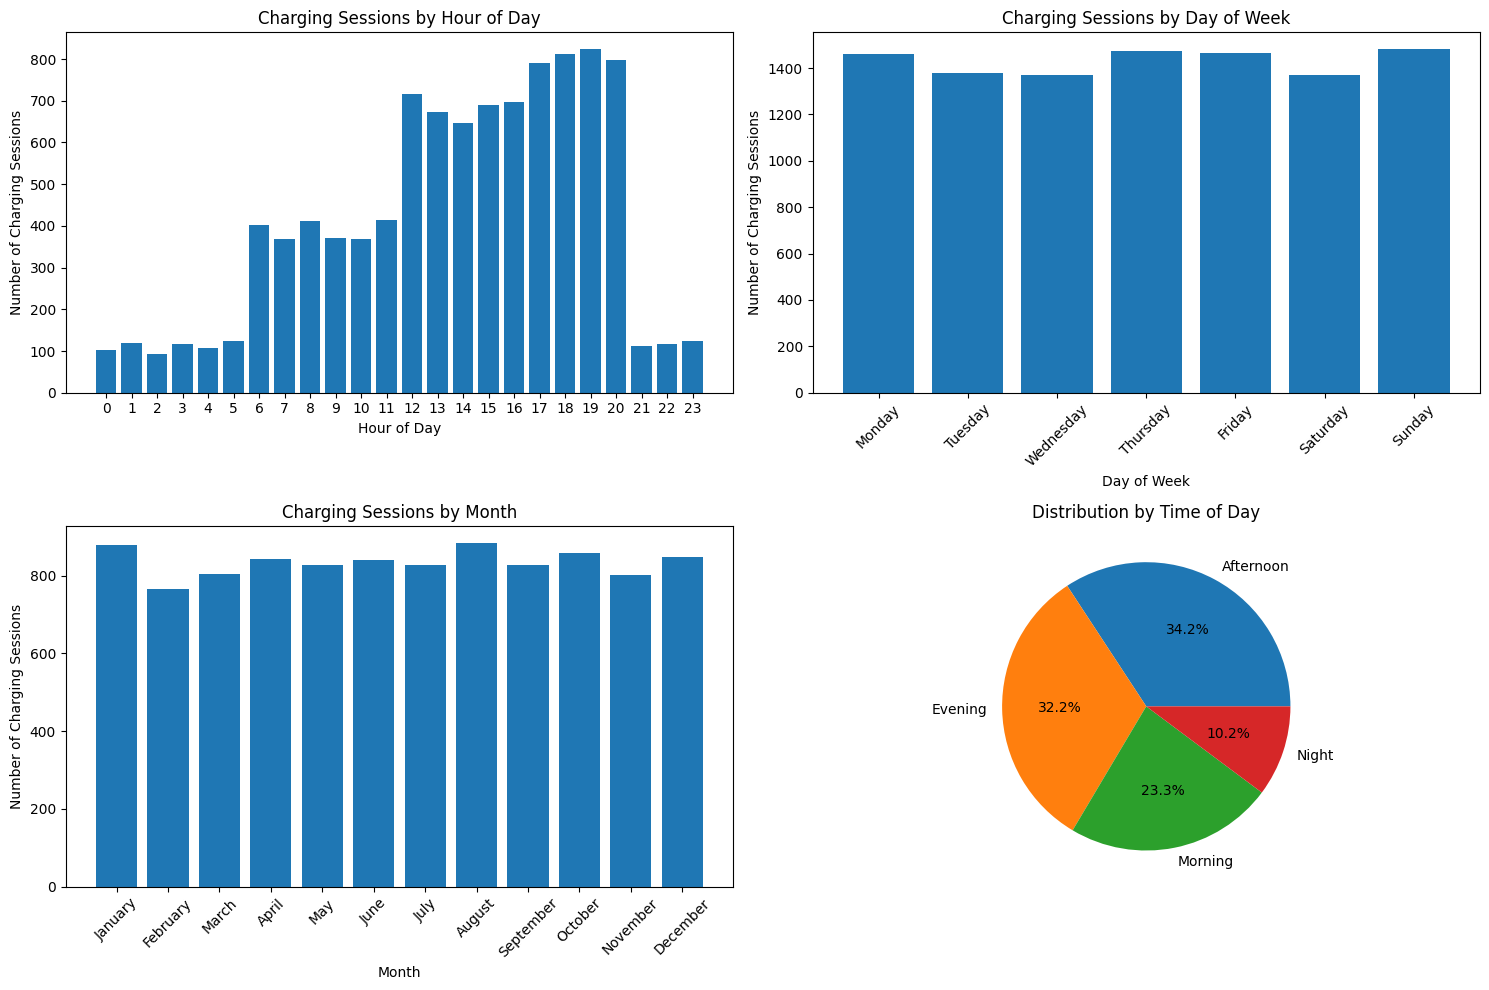

In [6]:
# Extract time features
df['Hour'] = df['Charging Start Time'].dt.hour
df['DayOfWeek'] = df['Charging Start Time'].dt.day_name()
df['Month'] = df['Charging Start Time'].dt.month_name()
df['Date'] = df['Charging Start Time'].dt.date

# 1. Hourly patterns
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
hourly_counts = df.groupby('Hour').size()
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Sessions')
plt.title('Charging Sessions by Hour of Day')
plt.xticks(range(0, 24))

# 2. Daily patterns (weekday vs weekend)
plt.subplot(2, 2, 2)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts = df.groupby('DayOfWeek').size().reindex(weekday_order)
plt.bar(daily_counts.index, daily_counts.values)
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Sessions')
plt.title('Charging Sessions by Day of Week')
plt.xticks(rotation=45)

# 3. Monthly patterns
plt.subplot(2, 2, 3)
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_counts = df.groupby('Month').size().reindex(month_order)
plt.bar(monthly_counts.index, monthly_counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Charging Sessions')
plt.title('Charging Sessions by Month')
plt.xticks(rotation=45)

# 4. Time of Day distribution
plt.subplot(2, 2, 4)
tod_counts = df['Time of Day'].value_counts()
plt.pie(tod_counts.values, labels=tod_counts.index, autopct='%1.1f%%')
plt.title('Distribution by Time of Day')

plt.tight_layout()
plt.show()

## Time series Analysis

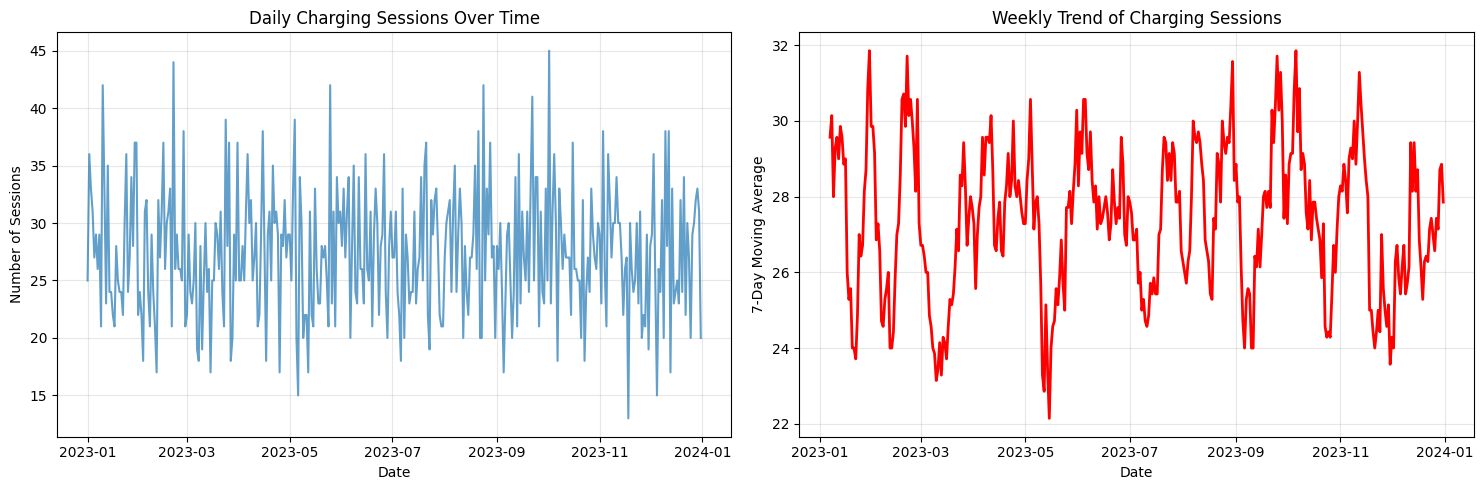

In [7]:
# Daily charging volume
plt.figure(figsize=(15, 5))

# Plot 1: Daily sessions over time
plt.subplot(1, 2, 1)
daily_volume = df.groupby('Date').size()
plt.plot(daily_volume.index, daily_volume.values, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Number of Sessions')
plt.title('Daily Charging Sessions Over Time')
plt.grid(True, alpha=0.3)

# Plot 2: Rolling average (7-day)
plt.subplot(1, 2, 2)
rolling_avg = daily_volume.rolling(window=7).mean()
plt.plot(rolling_avg.index, rolling_avg.values, color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('7-Day Moving Average')
plt.title('Weekly Trend of Charging Sessions')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3.Distribution Analysis

## Distribution Plot

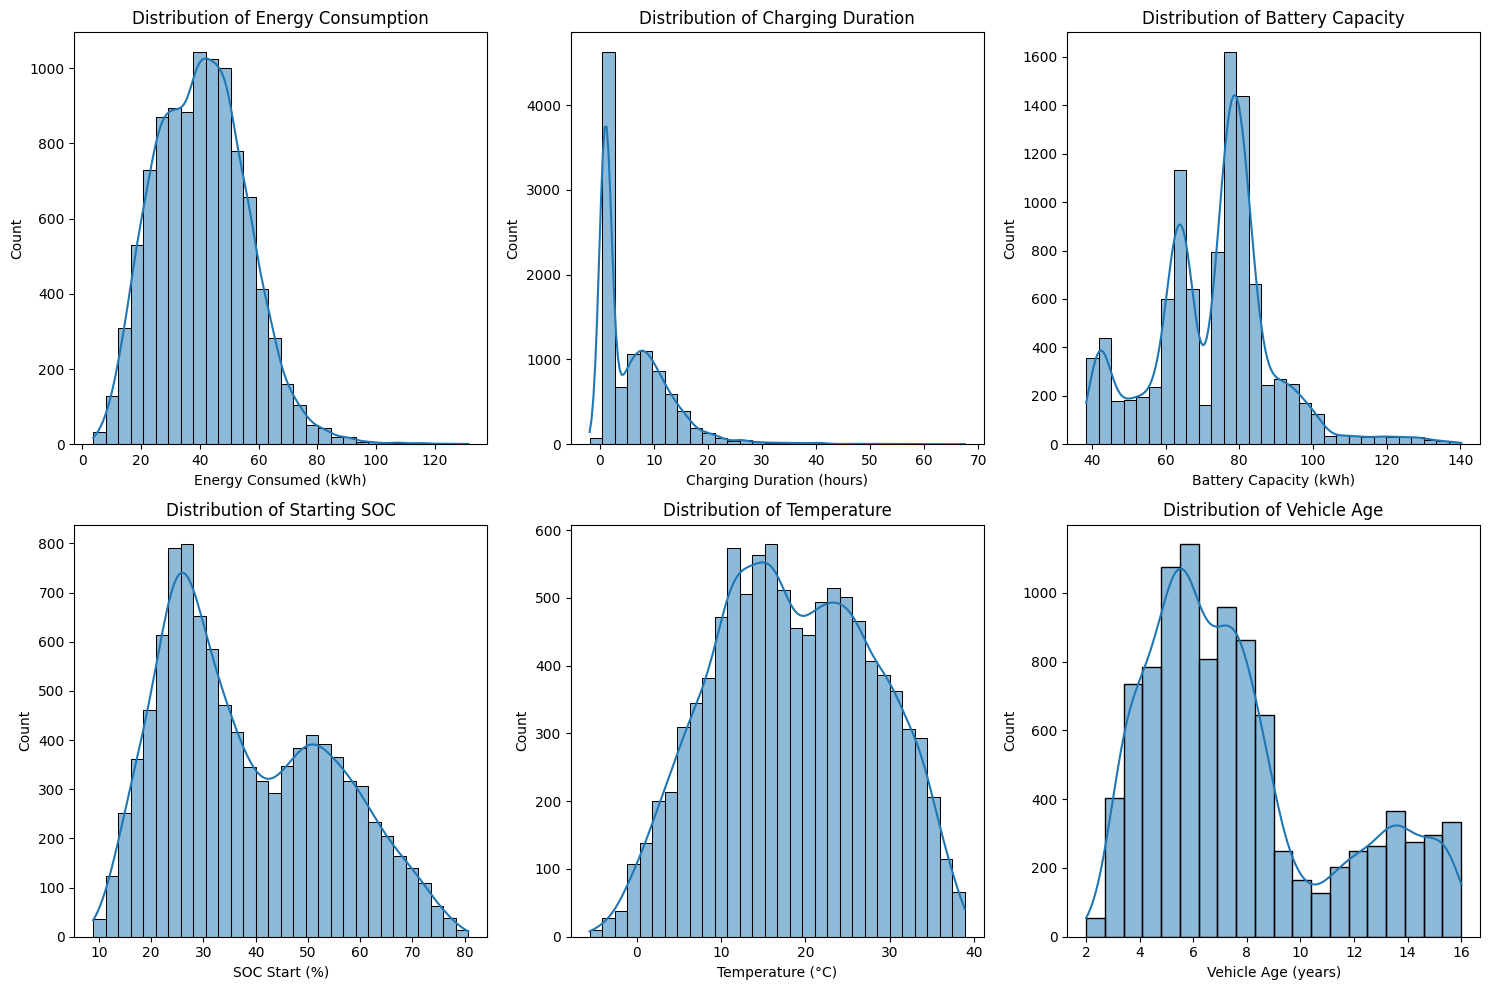

In [8]:
plt.figure(figsize=(15, 10))

# 1. Energy Consumption Distribution
plt.subplot(2, 3, 1)
sns.histplot(df['Energy Consumed (kWh)'], kde=True, bins=30)
plt.xlabel('Energy Consumed (kWh)')
plt.title('Distribution of Energy Consumption')

# 2. Charging Duration Distribution
plt.subplot(2, 3, 2)
sns.histplot(df['Charging Duration (hours)'], kde=True, bins=30)
plt.xlabel('Charging Duration (hours)')
plt.title('Distribution of Charging Duration')

# 3. Battery Capacity Distribution
plt.subplot(2, 3, 3)
sns.histplot(df['Battery Capacity (kWh)'], kde=True, bins=30)
plt.xlabel('Battery Capacity (kWh)')
plt.title('Distribution of Battery Capacity')

# 4. SOC Start Distribution
plt.subplot(2, 3, 4)
sns.histplot(df['State of Charge (Start %)'], kde=True, bins=30)
plt.xlabel('SOC Start (%)')
plt.title('Distribution of Starting SOC')

# 5. Temperature Distribution
plt.subplot(2, 3, 5)
sns.histplot(df['Temperature (C)'], kde=True, bins=30)
plt.xlabel('Temperature (°C)')
plt.title('Distribution of Temperature')

# 6. Vehicle Age Distribution
plt.subplot(2, 3, 6)
sns.histplot(df['Vehicle Age (years)'], kde=True, bins=20)
plt.xlabel('Vehicle Age (years)')
plt.title('Distribution of Vehicle Age')

plt.tight_layout()
plt.show()

## Box plots for outlier ditection

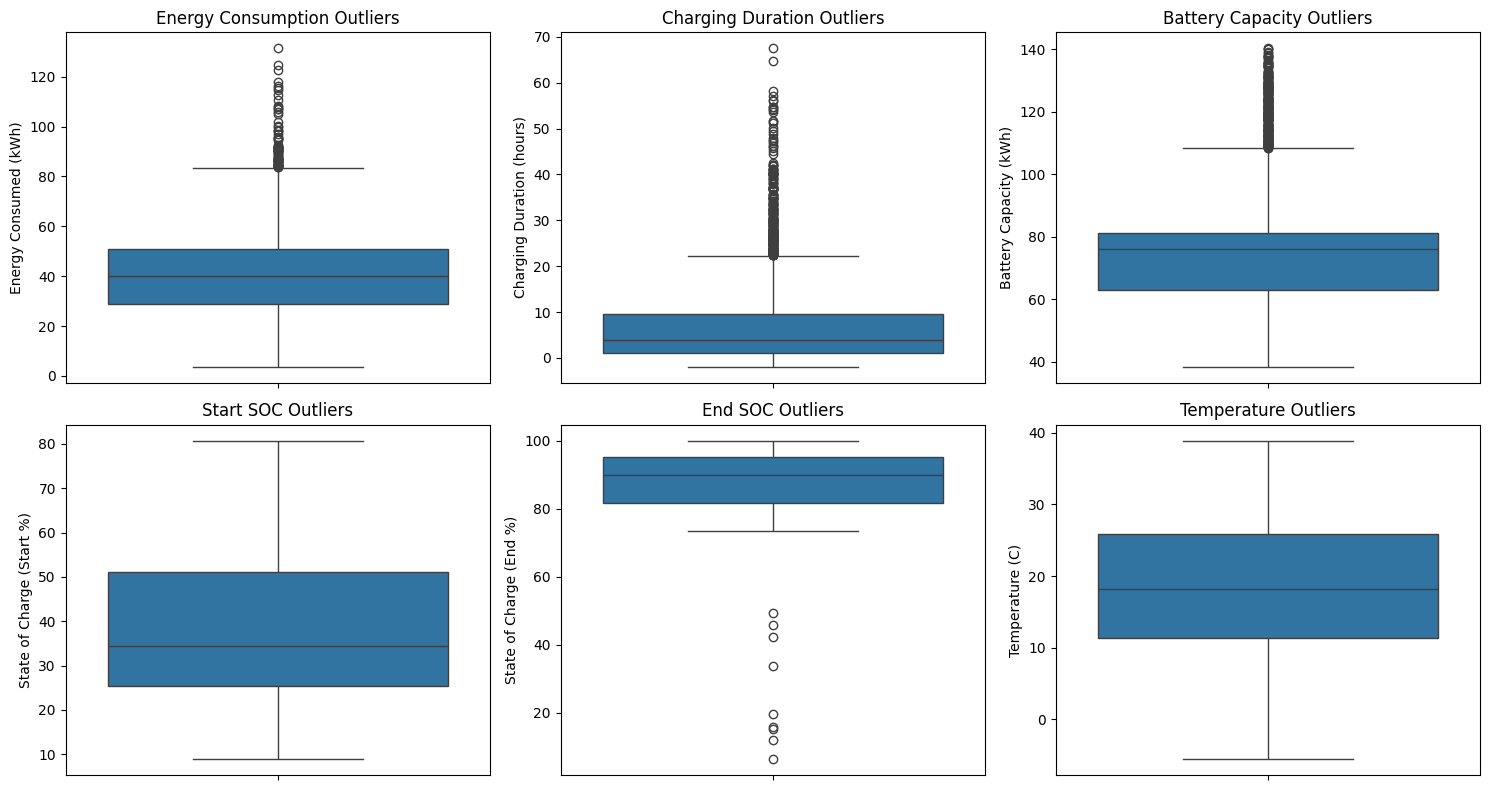

In [9]:
plt.figure(figsize=(15, 8))

# Box plots for key numerical features
plt.subplot(2, 3, 1)
sns.boxplot(y=df['Energy Consumed (kWh)'])
plt.title('Energy Consumption Outliers')

plt.subplot(2, 3, 2)
sns.boxplot(y=df['Charging Duration (hours)'])
plt.title('Charging Duration Outliers')

plt.subplot(2, 3, 3)
sns.boxplot(y=df['Battery Capacity (kWh)'])
plt.title('Battery Capacity Outliers')

plt.subplot(2, 3, 4)
sns.boxplot(y=df['State of Charge (Start %)'])
plt.title('Start SOC Outliers')

plt.subplot(2, 3, 5)
sns.boxplot(y=df['State of Charge (End %)'])
plt.title('End SOC Outliers')

plt.subplot(2, 3, 6)
sns.boxplot(y=df['Temperature (C)'])
plt.title('Temperature Outliers')

plt.tight_layout()
plt.show()

# 4.Catagorical analysis

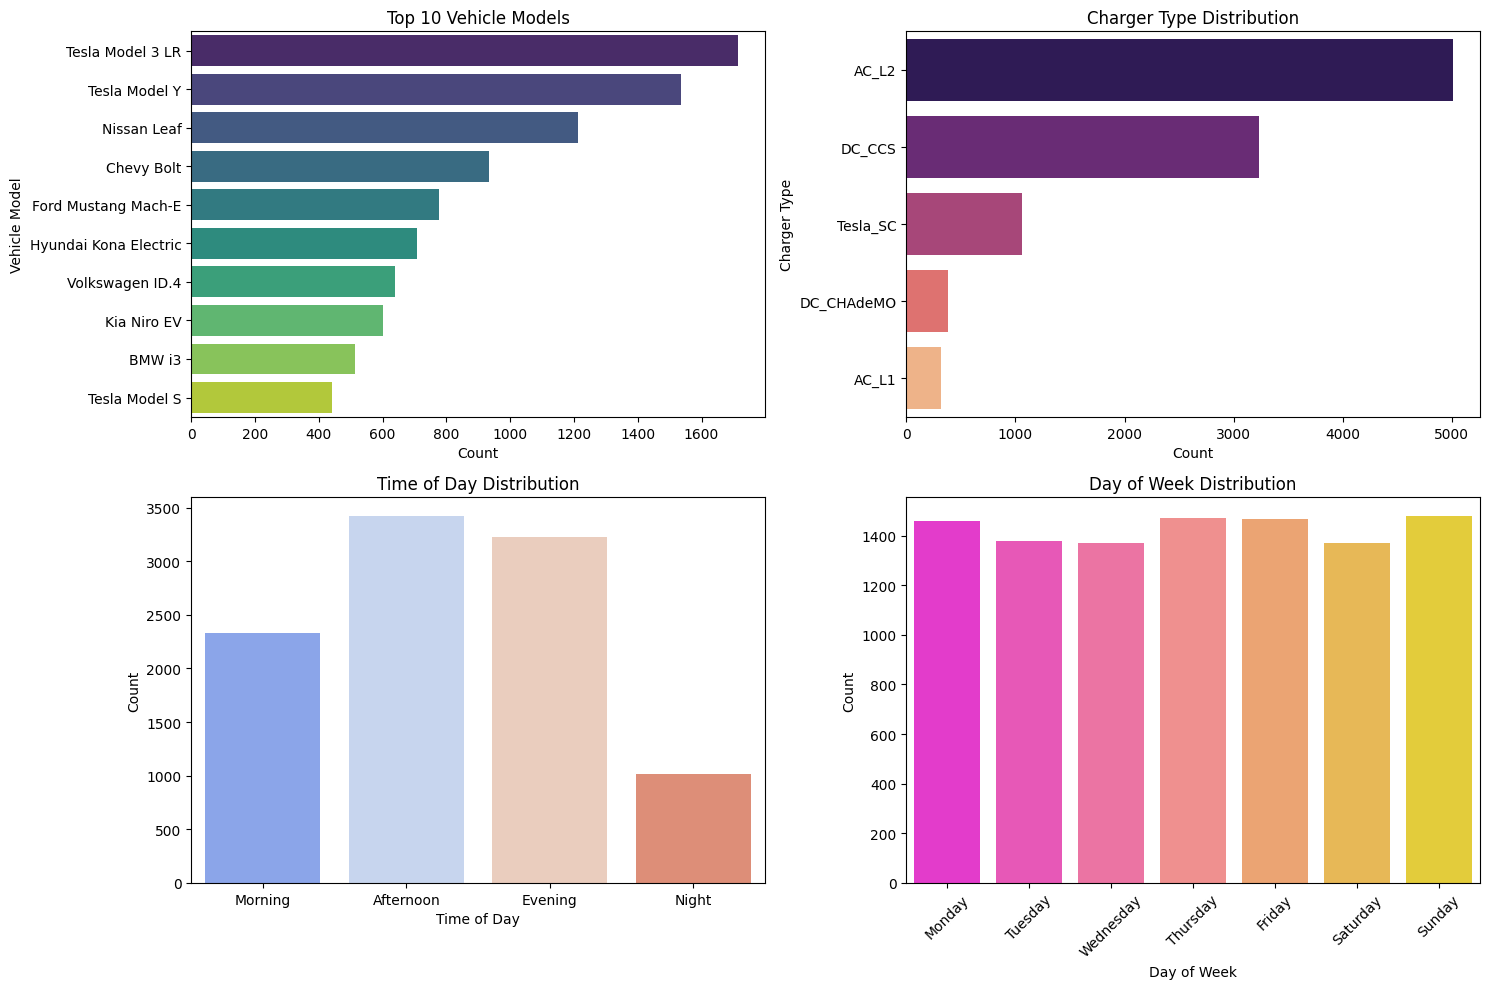

In [10]:
plt.figure(figsize=(15, 10))

# 1. Vehicle Model Distribution (Top 10)
plt.subplot(2, 2, 1)
top_models = df['Vehicle Model'].value_counts().head(10)
sns.barplot(x=top_models.values, y=top_models.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Vehicle Model')
plt.title('Top 10 Vehicle Models')

# 2. Charger Type Distribution
plt.subplot(2, 2, 2)
charger_dist = df['Charger Type'].value_counts()
sns.barplot(x=charger_dist.values, y=charger_dist.index, palette='magma')
plt.xlabel('Count')
plt.ylabel('Charger Type')
plt.title('Charger Type Distribution')

# 3. Time of Day Distribution
plt.subplot(2, 2, 3)
tod_order = ['Morning', 'Afternoon', 'Evening', 'Night']
tod_counts = df['Time of Day'].value_counts().reindex(tod_order)
sns.barplot(x=tod_counts.index, y=tod_counts.values, palette='coolwarm')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.title('Time of Day Distribution')

# 4. Day of Week Distribution
plt.subplot(2, 2, 4)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['DayOfWeek'].value_counts().reindex(day_order)
sns.barplot(x=day_counts.index, y=day_counts.values, palette='spring')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Day of Week Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 5.Correlation Analysis

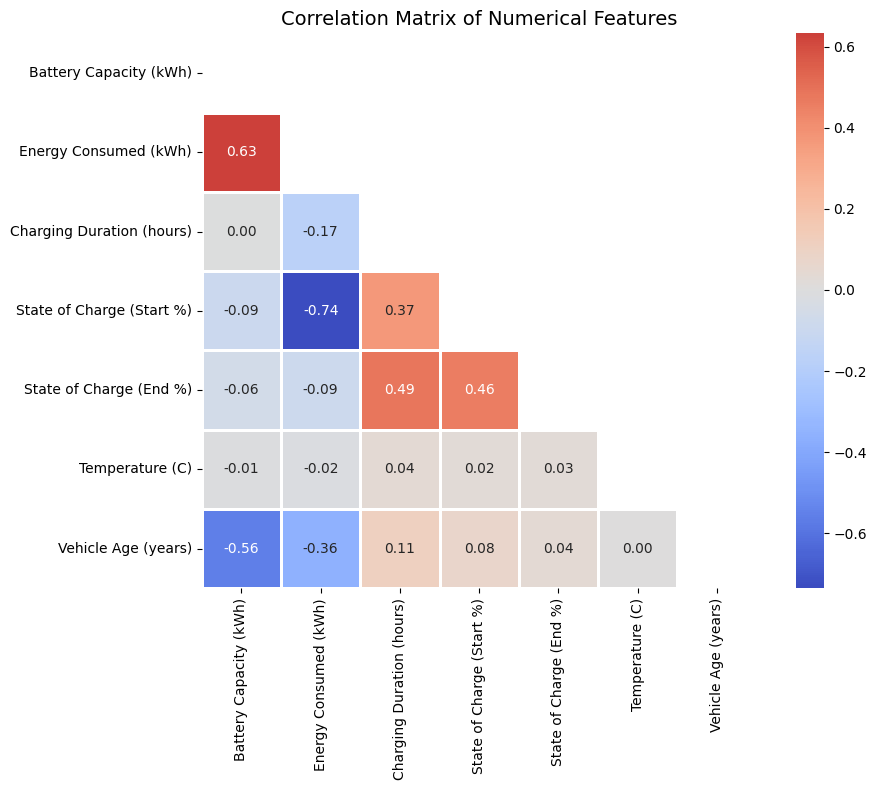

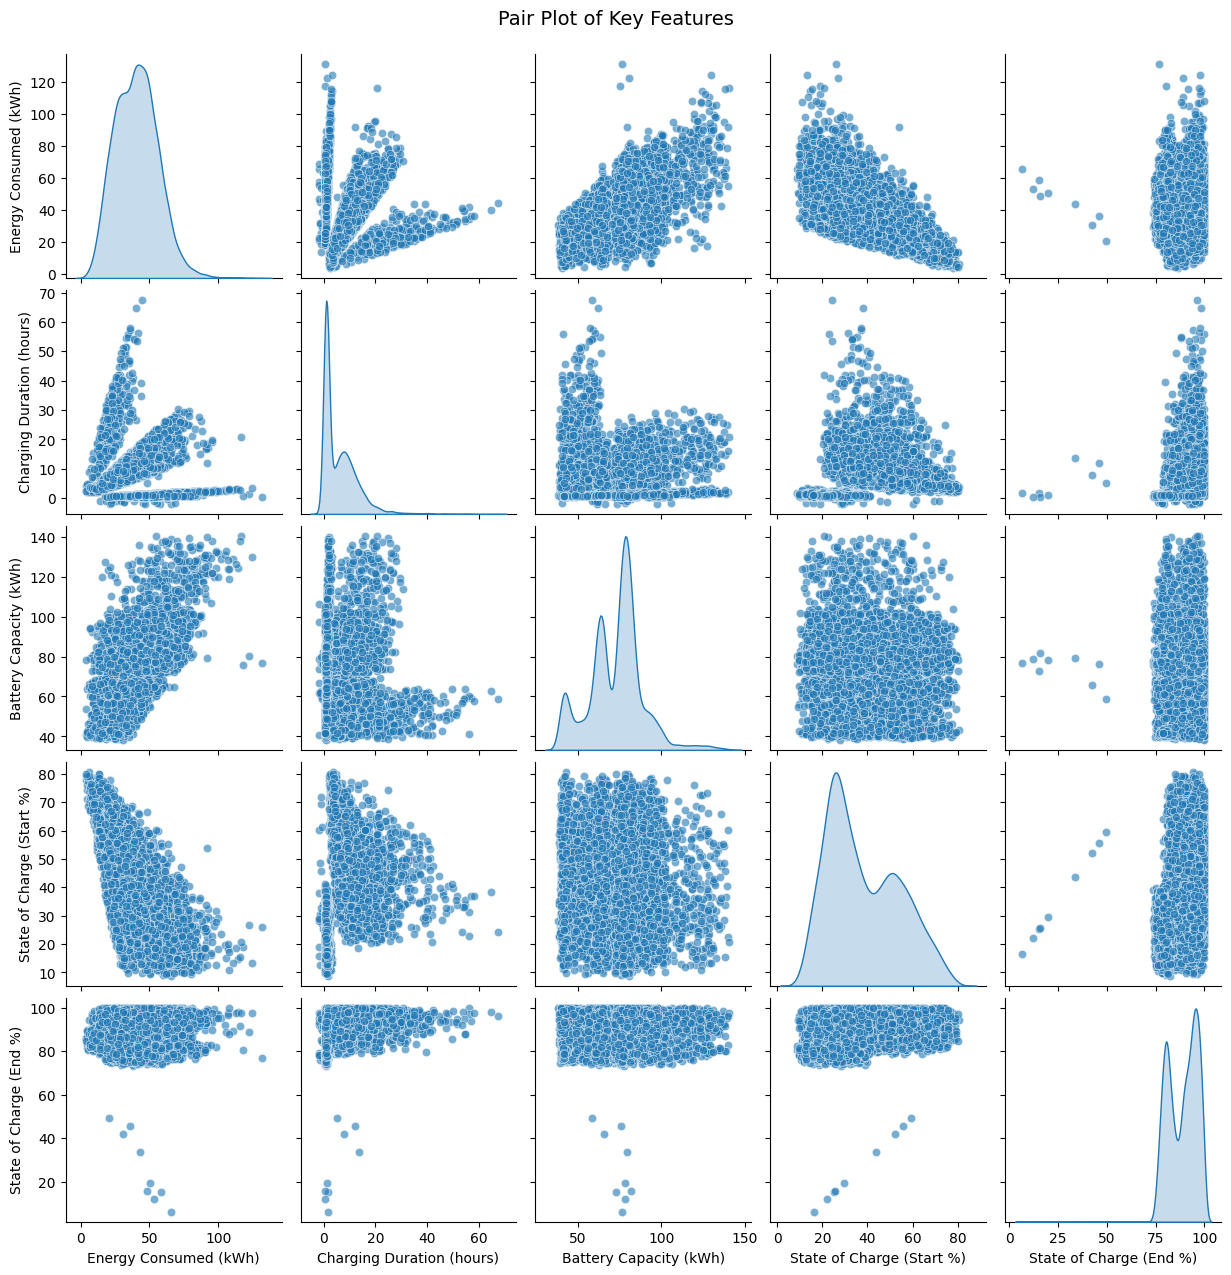

In [11]:
# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
            center=0, square=True, linewidths=1, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

# Scatter plot matrix for key relationships
selected_features = ['Energy Consumed (kWh)', 'Charging Duration (hours)',
                     'Battery Capacity (kWh)', 'State of Charge (Start %)',
                     'State of Charge (End %)']

sns.pairplot(df[selected_features], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot of Key Features', y=1.02, fontsize=14)
plt.show()

## Target Variable Relationship

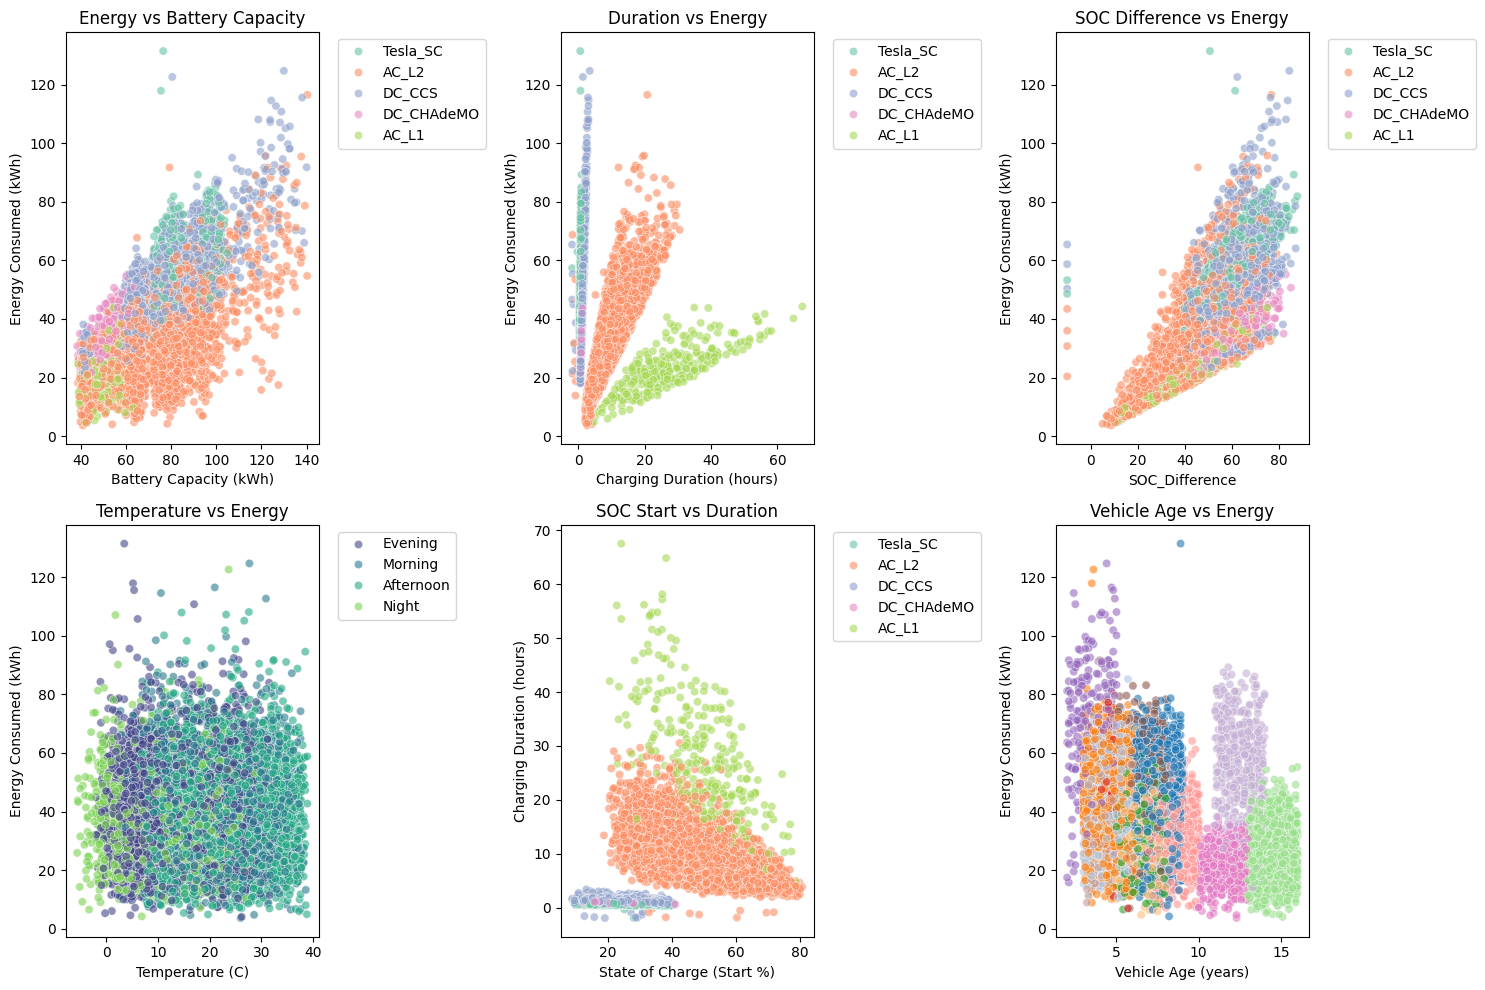

In [12]:
plt.figure(figsize=(15, 10))

# 1. Energy vs Battery Capacity (colored by charger type)
plt.subplot(2, 3, 1)
sns.scatterplot(data=df, x='Battery Capacity (kWh)', y='Energy Consumed (kWh)',
                hue='Charger Type', alpha=0.6, palette='Set2')
plt.title('Energy vs Battery Capacity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Duration vs Energy (colored by charger type)
plt.subplot(2, 3, 2)
sns.scatterplot(data=df, x='Charging Duration (hours)', y='Energy Consumed (kWh)',
                hue='Charger Type', alpha=0.6, palette='Set2')
plt.title('Duration vs Energy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. SOC Difference vs Energy
df['SOC_Difference'] = df['State of Charge (End %)'] - df['State of Charge (Start %)']
plt.subplot(2, 3, 3)
sns.scatterplot(data=df, x='SOC_Difference', y='Energy Consumed (kWh)',
                alpha=0.6, hue='Charger Type', palette='Set2')
plt.title('SOC Difference vs Energy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Energy vs Temperature
plt.subplot(2, 3, 4)
sns.scatterplot(data=df, x='Temperature (C)', y='Energy Consumed (kWh)',
                alpha=0.6, hue='Time of Day', palette='viridis')
plt.title('Temperature vs Energy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 5. Duration vs SOC Start
plt.subplot(2, 3, 5)
sns.scatterplot(data=df, x='State of Charge (Start %)', y='Charging Duration (hours)',
                alpha=0.6, hue='Charger Type', palette='Set2')
plt.title('SOC Start vs Duration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 6. Energy vs Vehicle Age
plt.subplot(2, 3, 6)
sns.scatterplot(data=df, x='Vehicle Age (years)', y='Energy Consumed (kWh)',
                alpha=0.6, hue='Vehicle Model', palette='tab20')
plt.title('Vehicle Age vs Energy')
plt.legend().remove()

plt.tight_layout()
plt.show()

# 6. Multivariative Analysis

## Charger Type Analysis

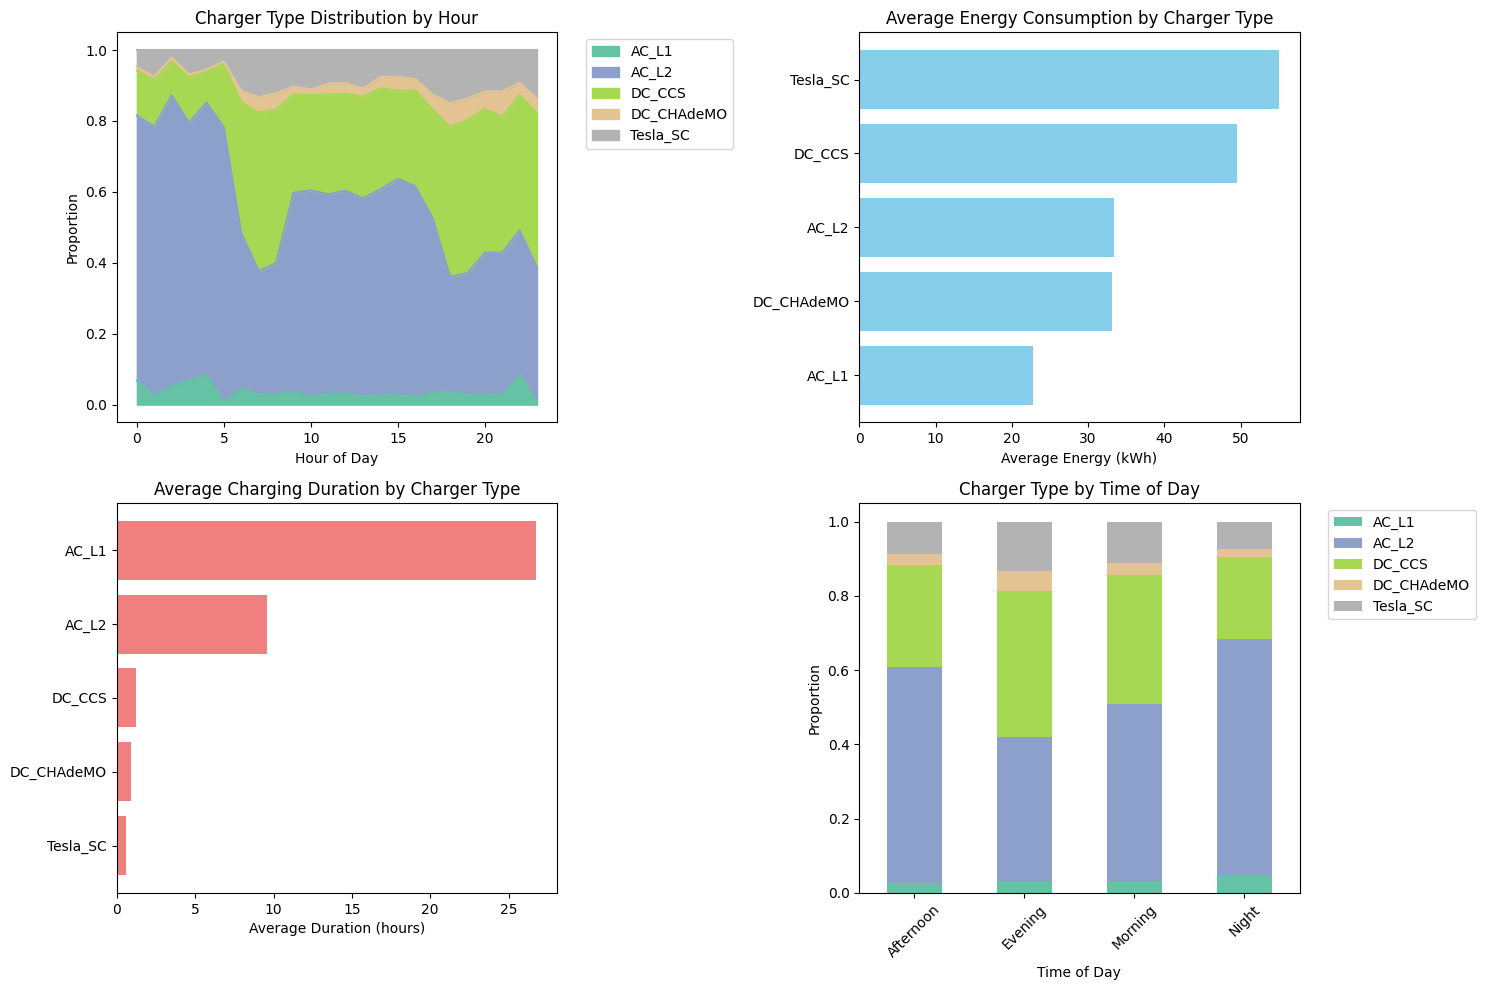

In [13]:
# Charger type analysis by time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Charger type distribution by hour
hourly_charger = pd.crosstab(df['Hour'], df['Charger Type'], normalize='index')
hourly_charger.plot(kind='area', stacked=True, ax=axes[0, 0], colormap='Set2')
axes[0, 0].set_title('Charger Type Distribution by Hour')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Proportion')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Average energy by charger type
avg_energy_by_charger = df.groupby('Charger Type')['Energy Consumed (kWh)'].mean().sort_values()
axes[0, 1].barh(avg_energy_by_charger.index, avg_energy_by_charger.values, color='skyblue')
axes[0, 1].set_title('Average Energy Consumption by Charger Type')
axes[0, 1].set_xlabel('Average Energy (kWh)')

# 3. Average duration by charger type
avg_duration_by_charger = df.groupby('Charger Type')['Charging Duration (hours)'].mean().sort_values()
axes[1, 0].barh(avg_duration_by_charger.index, avg_duration_by_charger.values, color='lightcoral')
axes[1, 0].set_title('Average Charging Duration by Charger Type')
axes[1, 0].set_xlabel('Average Duration (hours)')

# 4. Charger type by time of day
tod_charger = pd.crosstab(df['Time of Day'], df['Charger Type'], normalize='index')
tod_charger.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='Set2')
axes[1, 1].set_title('Charger Type by Time of Day')
axes[1, 1].set_xlabel('Time of Day')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Vehicle Mode Analysis

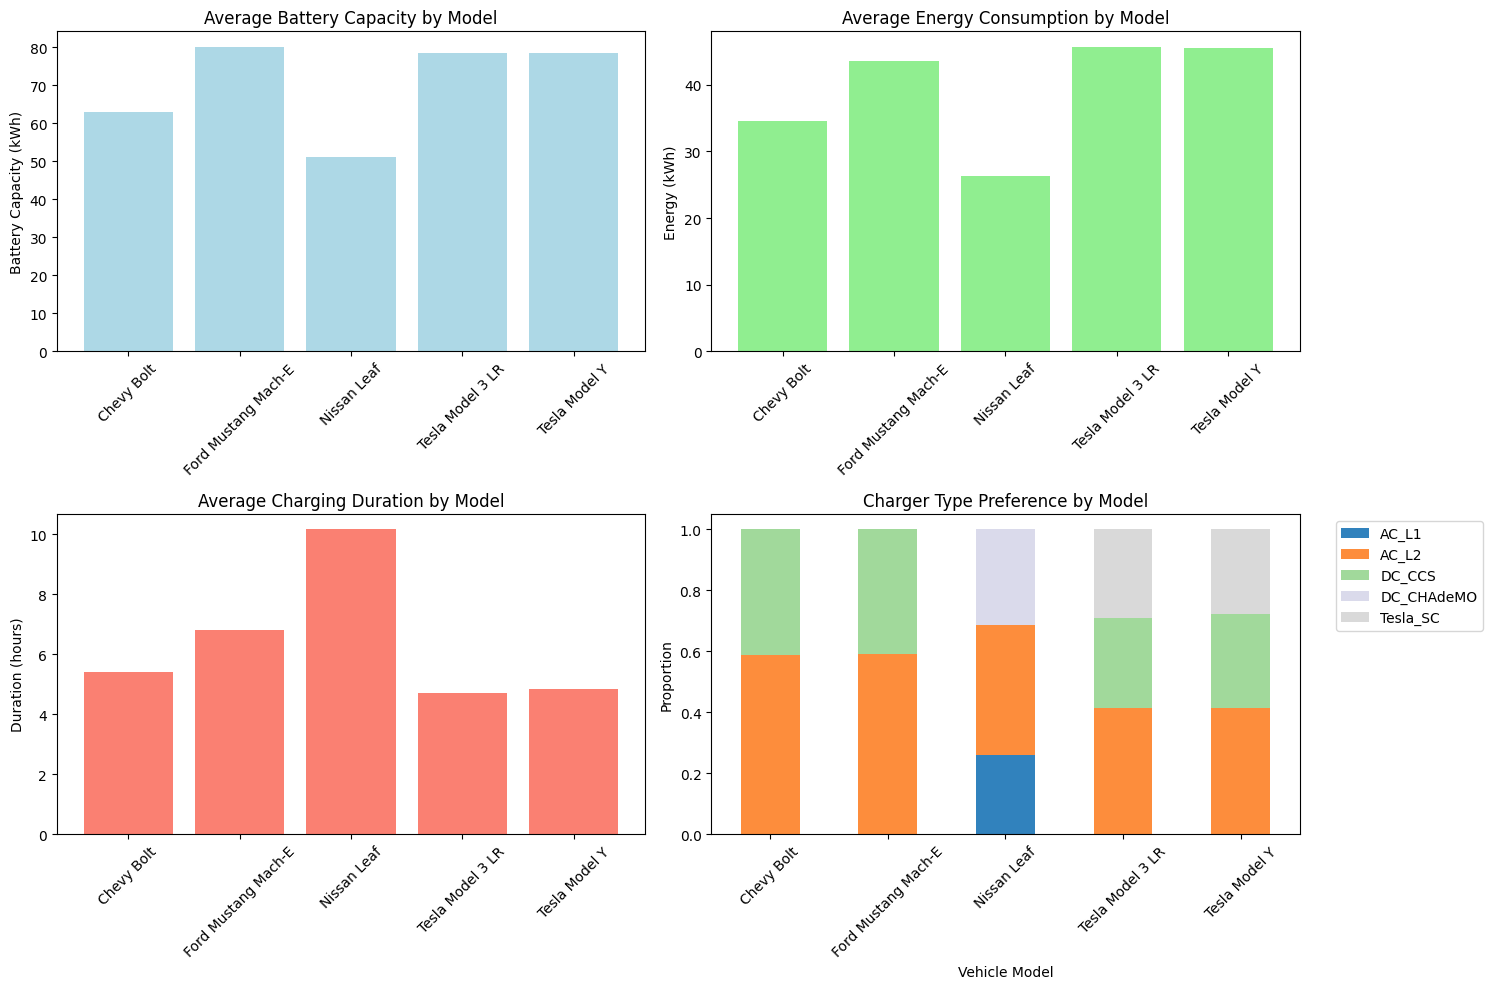

In [14]:
# Top vehicle models analysis
top_5_models = df['Vehicle Model'].value_counts().head(5).index
top_models_df = df[df['Vehicle Model'].isin(top_5_models)]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Average battery capacity by model
battery_by_model = top_models_df.groupby('Vehicle Model')['Battery Capacity (kWh)'].mean()
axes[0, 0].bar(battery_by_model.index, battery_by_model.values, color='lightblue')
axes[0, 0].set_title('Average Battery Capacity by Model')
axes[0, 0].set_ylabel('Battery Capacity (kWh)')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Average energy consumption by model
energy_by_model = top_models_df.groupby('Vehicle Model')['Energy Consumed (kWh)'].mean()
axes[0, 1].bar(energy_by_model.index, energy_by_model.values, color='lightgreen')
axes[0, 1].set_title('Average Energy Consumption by Model')
axes[0, 1].set_ylabel('Energy (kWh)')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Average charging duration by model
duration_by_model = top_models_df.groupby('Vehicle Model')['Charging Duration (hours)'].mean()
axes[1, 0].bar(duration_by_model.index, duration_by_model.values, color='salmon')
axes[1, 0].set_title('Average Charging Duration by Model')
axes[1, 0].set_ylabel('Duration (hours)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Preferred charger type by model
charger_by_model = pd.crosstab(top_models_df['Vehicle Model'], top_models_df['Charger Type'], normalize='index')
charger_by_model.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='tab20c')
axes[1, 1].set_title('Charger Type Preference by Model')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#Advanced Visualization

## Interactive Heatmaps

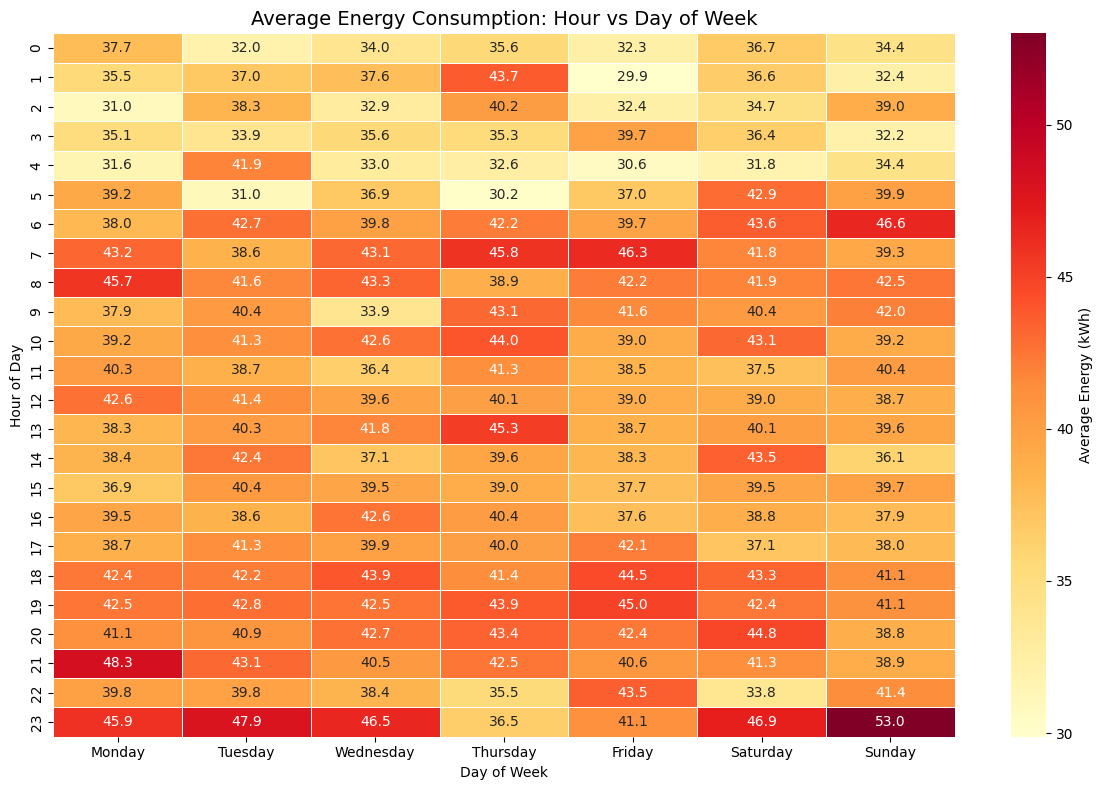

In [15]:
# Create time-based heatmap
pivot_data = df.pivot_table(index='Hour', columns='DayOfWeek',
                            values='Energy Consumed (kWh)', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data.reindex(columns=day_order), cmap='YlOrRd',
            linewidths=0.5, annot=True, fmt='.1f', cbar_kws={'label': 'Average Energy (kWh)'})
plt.title('Average Energy Consumption: Hour vs Day of Week', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()

## Feature Engineering insight

In [17]:
# Calculate derived features for model building
print("="*60)
print("FEATURE ENGINEERING INSIGHTS")
print("="*60)



# 2. SOC change
df['SOC_Change'] = df['State of Charge (End %)'] - df['State of Charge (Start %)']
print(f"\nAverage SOC change: {df['SOC_Change'].mean():.1f}%")

# 3. Efficiency (energy delivered to battery / energy consumed)
df['Efficiency'] = (df['Battery Capacity (kWh)'] * df['SOC_Change'] / 100) / df['Energy Consumed (kWh)']
print(f"\nAverage charging efficiency: {df['Efficiency'].mean():.3f}")
print(f"Efficiency by charger type:")
print(df.groupby('Charger Type')['Efficiency'].mean().round(3))

# 4. Time-based features
df['Is_Weekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)
df['Is_Peak_Hour'] = ((df['Hour'] >= 17) & (df['Hour'] <= 21)).astype(int)

print(f"\nWeekend sessions: {df['Is_Weekend'].mean()*100:.1f}%")
print(f"Peak hour sessions: {df['Is_Peak_Hour'].mean()*100:.1f}%")

# 5. Battery utilization
df['Battery_Utilization'] = df['Energy Consumed (kWh)'] / df['Battery Capacity (kWh)']
print(f"\nAverage battery utilization: {df['Battery_Utilization'].mean()*100:.1f}%")

FEATURE ENGINEERING INSIGHTS

Average SOC change: 50.5%

Average charging efficiency: 0.918
Efficiency by charger type:
Charger Type
AC_L1         0.950
AC_L2         0.939
DC_CCS        0.899
DC_CHAdeMO    0.900
Tesla_SC      0.877
Name: Efficiency, dtype: float64

Weekend sessions: 28.5%
Peak hour sessions: 33.4%

Average battery utilization: 55.3%


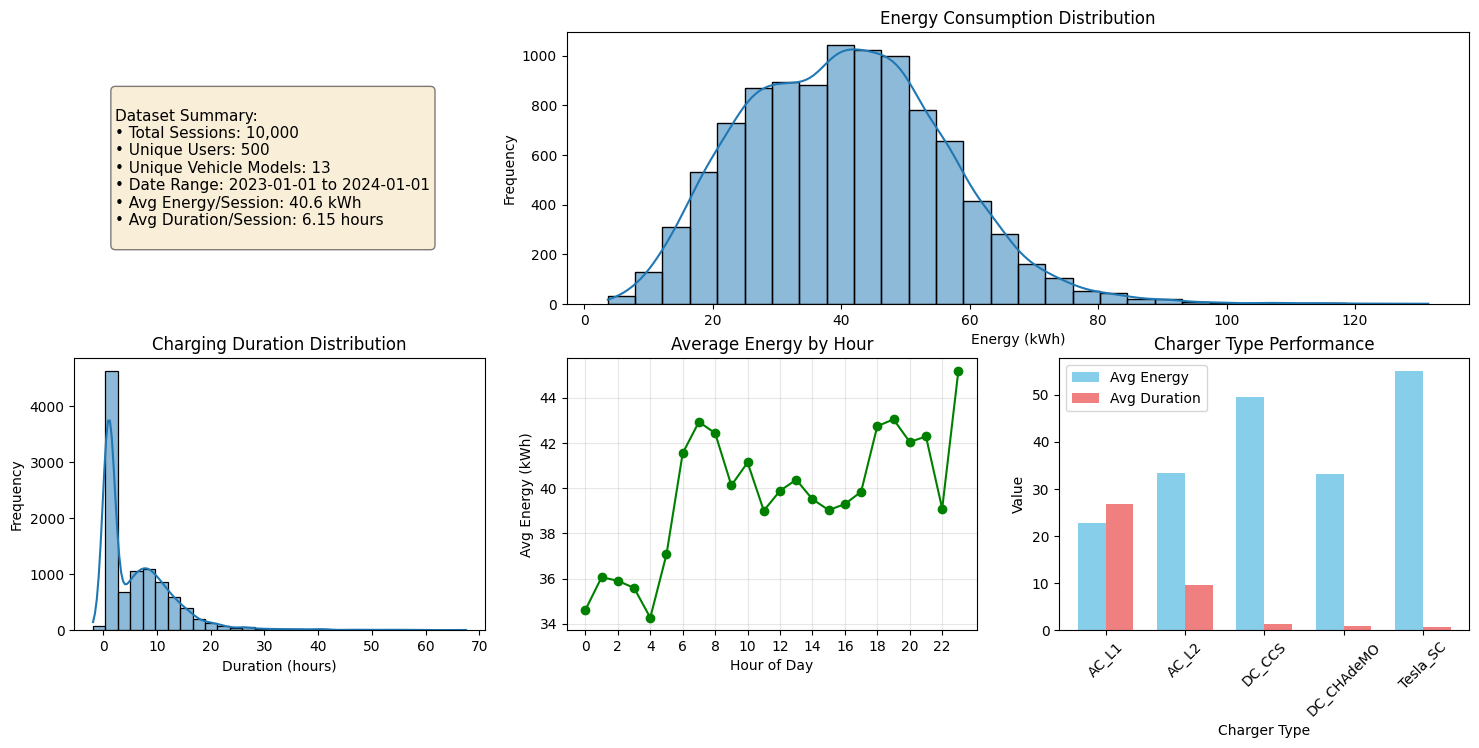

In [19]:
# Create summary statistics dashboard
fig = plt.figure(figsize=(18, 12))

# GridSpec for complex layout
gs = fig.add_gridspec(3, 3)

# 1. Overall stats (text)
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
summary_text = f"""
Dataset Summary:
• Total Sessions: {len(df):,}
• Unique Users: {df['User ID'].nunique():,}
• Unique Vehicle Models: {df['Vehicle Model'].nunique()}
• Date Range: {df['Charging Start Time'].min().date()} to {df['Charging End Time'].max().date()}
• Avg Energy/Session: {df['Energy Consumed (kWh)'].mean():.1f} kWh
• Avg Duration/Session: {df['Charging Duration (hours)'].mean():.2f} hours
"""
ax1.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Energy distribution
ax2 = fig.add_subplot(gs[0, 1:])
sns.histplot(df['Energy Consumed (kWh)'], kde=True, ax=ax2, bins=30)
ax2.set_title('Energy Consumption Distribution', fontsize=12)
ax2.set_xlabel('Energy (kWh)')
ax2.set_ylabel('Frequency')

# 3. Duration distribution
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(df['Charging Duration (hours)'], kde=True, ax=ax3, bins=30)
ax3.set_title('Charging Duration Distribution', fontsize=12)
ax3.set_xlabel('Duration (hours)')
ax3.set_ylabel('Frequency')

# 4. Hourly pattern
ax4 = fig.add_subplot(gs[1, 1])
hourly_avg_energy = df.groupby('Hour')['Energy Consumed (kWh)'].mean()
ax4.plot(hourly_avg_energy.index, hourly_avg_energy.values, marker='o', color='green')
ax4.set_title('Average Energy by Hour', fontsize=12)
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Avg Energy (kWh)')
ax4.set_xticks(range(0, 24, 2))
ax4.grid(True, alpha=0.3)

# 5. Charger type comparison
ax5 = fig.add_subplot(gs[1, 2])
charger_stats = df.groupby('Charger Type').agg({
    'Energy Consumed (kWh)': 'mean',
    'Charging Duration (hours)': 'mean'
})
x = np.arange(len(charger_stats))
width = 0.35
ax5.bar(x - width/2, charger_stats['Energy Consumed (kWh)'], width, label='Avg Energy', color='skyblue')
ax5.bar(x + width/2, charger_stats['Charging Duration (hours)'], width, label='Avg Duration', color='lightcoral')
ax5.set_title('Charger Type Performance', fontsize=12)
ax5.set_xlabel('Charger Type')
ax5.set_ylabel('Value')
ax5.set_xticks(x)
ax5.set_xticklabels(charger_stats.index, rotation=45)
ax5.legend()



# Building Predictive Models for EV Charging Data

## Data loading & Initial Preperation

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
df = pd.read_csv('ev_charging_dataset.csv', parse_dates=['Charging Start Time', 'Charging End Time'])

# Create derived features (from EDA)
df['Hour'] = df['Charging Start Time'].dt.hour
df['DayOfWeek'] = df['Charging Start Time'].dt.day_name()
df['Month'] = df['Charging Start Time'].dt.month
df['Is_Weekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)
df['Is_Peak_Hour'] = ((df['Hour'] >= 17) & (df['Hour'] <= 21)).astype(int)
df['SOC_Change'] = df['State of Charge (End %)'] - df['State of Charge (Start %)']
df['Charging_Rate_kW'] = df['Energy Consumed (kWh)'] / df['Charging Duration (hours)']
df['Battery_Utilization'] = df['Energy Consumed (kWh)'] / df['Battery Capacity (kWh)']

# Remove data errors (keep for anomaly detection if needed)
df_clean = df.copy()
df_clean = df_clean[df_clean['Charging Duration (hours)'] > 0]
df_clean = df_clean[df_clean['State of Charge (End %)'] > df_clean['State of Charge (Start %)']]
df_clean = df_clean[df_clean['Energy Consumed (kWh)'] <= df_clean['Battery Capacity (kWh)'] * 1.5]

print(f"Original records: {len(df)}")
print(f"Clean records: {len(df_clean)}")
print(f"Records removed: {len(df) - len(df_clean)}")

Original records: 10000
Clean records: 9969
Records removed: 31


## Feature Engineering Strategy

In [21]:
# Define feature categories
features = {
    # Vehicle Characteristics
    'vehicle_features': ['Battery Capacity (kWh)', 'Vehicle Age (years)'],

    # Charging Context
    'charging_features': ['State of Charge (Start %)', 'SOC_Change', 'Charger Type'],

    # Temporal Features
    'temporal_features': ['Hour', 'DayOfWeek', 'Month', 'Is_Weekend', 'Is_Peak_Hour', 'Time of Day'],

    # Environmental
    'environmental_features': ['Temperature (C)'],

    # Derived/Engineering Features
    'derived_features': ['Battery_Utilization'],

    # Target Variables (for feature selection)
    'targets': ['Energy Consumed (kWh)', 'Charging Duration (hours)']
}

# Create feature matrix
def create_feature_matrix(df):
    """Create comprehensive feature matrix with proper encoding"""

    # Start with numerical features
    X = df[features['vehicle_features'] + features['charging_features'][:2] +
           features['environmental_features'] + features['derived_features']].copy()

    # Add temporal features with encoding
    X['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    X['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    X['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
    X['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)

    # Binary features
    X['Is_Weekend'] = df['Is_Weekend']
    X['Is_Peak_Hour'] = df['Is_Peak_Hour']

    # One-hot encode categorical features
    charger_dummies = pd.get_dummies(df['Charger Type'], prefix='Charger')
    time_dummies = pd.get_dummies(df['Time of Day'], prefix='Time')
    day_dummies = pd.get_dummies(df['DayOfWeek'], prefix='Day')

    # Combine all features
    X = pd.concat([X, charger_dummies, time_dummies, day_dummies], axis=1)

    # Add interaction features
    X['Capacity_SOC_Interaction'] = X['Battery Capacity (kWh)'] * X['State of Charge (Start %)']
    X['Capacity_Temp_Interaction'] = X['Battery Capacity (kWh)'] * X['Temperature (C)']
    X['SOC_Temp_Interaction'] = X['State of Charge (Start %)'] * X['Temperature (C)']

    return X

# Create feature matrix
X = create_feature_matrix(df_clean)

# Define targets
y_energy = df_clean['Energy Consumed (kWh)']
y_duration = df_clean['Charging Duration (hours)']

print(f"Feature matrix shape: {X.shape}")
print(f"\nFeature columns:")
print(X.columns.tolist())

Feature matrix shape: (9969, 31)

Feature columns:
['Battery Capacity (kWh)', 'Vehicle Age (years)', 'State of Charge (Start %)', 'SOC_Change', 'Temperature (C)', 'Battery_Utilization', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Is_Weekend', 'Is_Peak_Hour', 'Charger_AC_L1', 'Charger_AC_L2', 'Charger_DC_CCS', 'Charger_DC_CHAdeMO', 'Charger_Tesla_SC', 'Time_Afternoon', 'Time_Evening', 'Time_Morning', 'Time_Night', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'Capacity_SOC_Interaction', 'Capacity_Temp_Interaction', 'SOC_Temp_Interaction']


## Feature Selection Analysis


FEATURE IMPORTANCE ANALYSIS for Energy Consumption


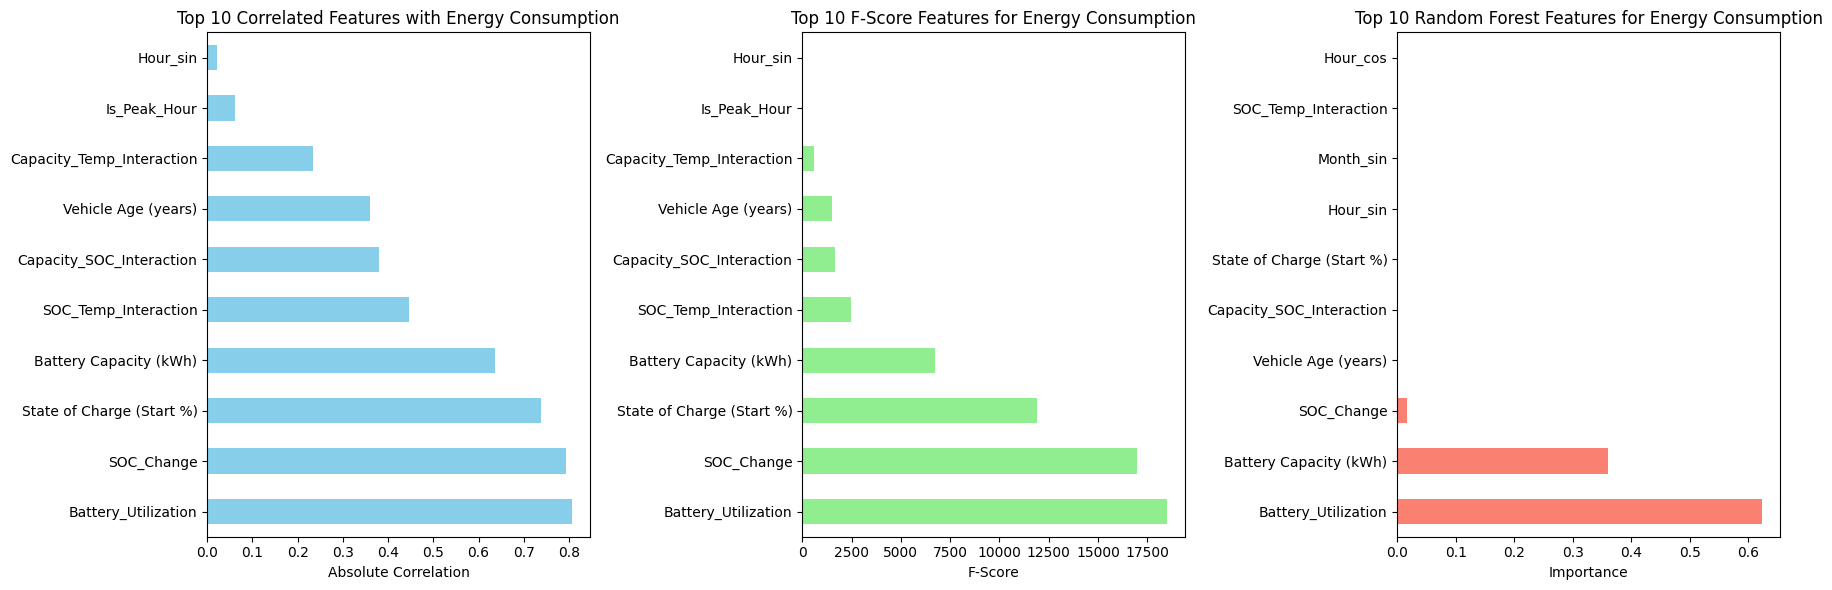


Top 15 Features for predicting Energy Consumption:
['Battery_Utilization', 'SOC_Change', 'Battery Capacity (kWh)', 'State of Charge (Start %)', 'Capacity_SOC_Interaction', 'Vehicle Age (years)', 'SOC_Temp_Interaction', 'Capacity_Temp_Interaction', 'Hour_sin', 'Is_Peak_Hour', 'Temperature (C)', 'Is_Weekend', 'Hour_cos', 'Month_sin', 'Month_cos']

FEATURE IMPORTANCE ANALYSIS for Charging Duration


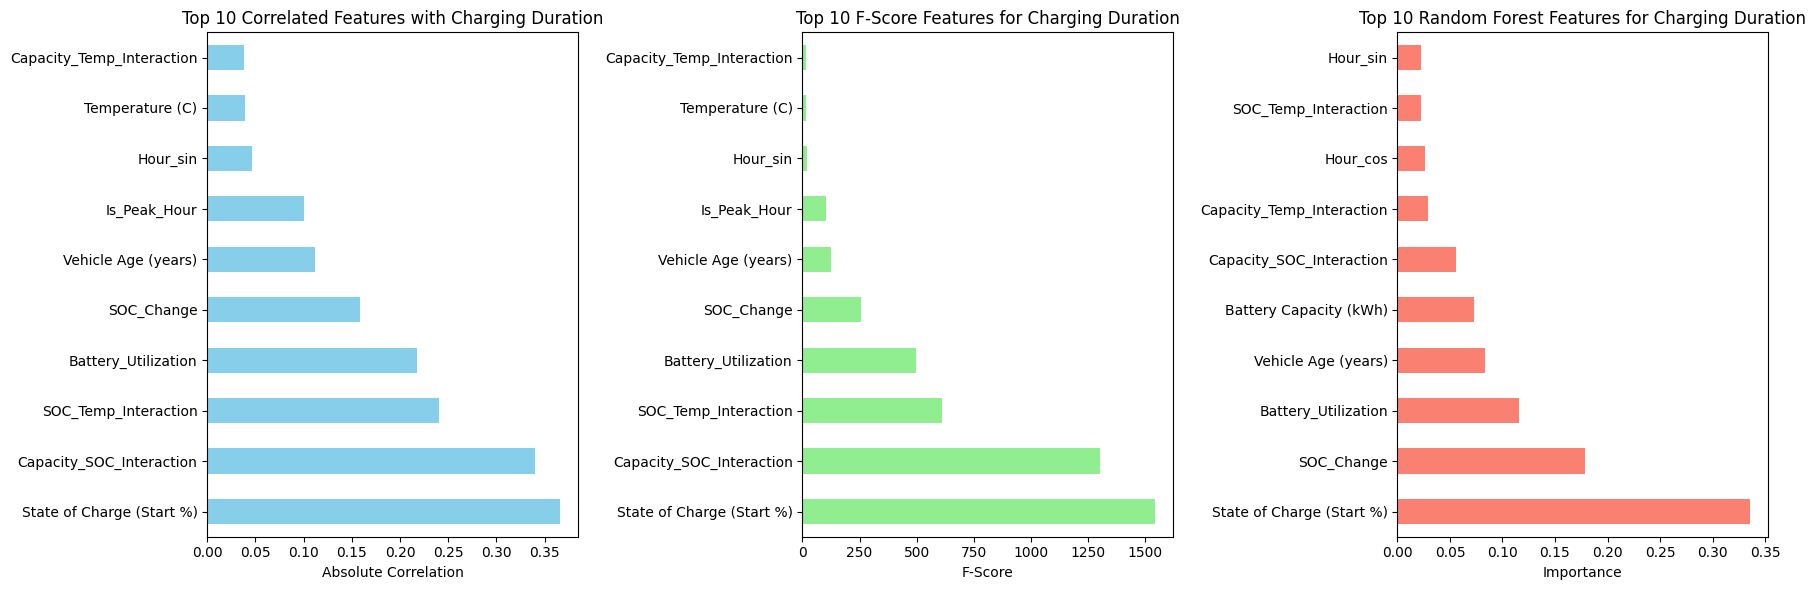


Top 15 Features for predicting Charging Duration:
['State of Charge (Start %)', 'Capacity_SOC_Interaction', 'Battery_Utilization', 'SOC_Change', 'SOC_Temp_Interaction', 'Vehicle Age (years)', 'Hour_sin', 'Capacity_Temp_Interaction', 'Temperature (C)', 'Is_Peak_Hour', 'Hour_cos', 'Battery Capacity (kWh)', 'Month_cos', 'Is_Weekend', 'Month_sin']

Selected important features: ['Capacity_Temp_Interaction', 'Vehicle Age (years)', 'Is_Peak_Hour', 'Hour_sin', 'Battery_Utilization', 'SOC_Change', 'Temperature (C)', 'State of Charge (Start %)', 'SOC_Temp_Interaction', 'Battery Capacity (kWh)', 'Capacity_SOC_Interaction']


In [22]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

def analyze_feature_importance(X, y, target_name):
    """Analyze feature importance using multiple methods"""

    print(f"\n{'='*60}")
    print(f"FEATURE IMPORTANCE ANALYSIS for {target_name}")
    print(f"{'='*60}")

    # Method 1: Correlation analysis
    correlations = {}
    for col in X.select_dtypes(include=[np.number]).columns:
        corr = np.corrcoef(X[col], y)[0, 1]
        correlations[col] = abs(corr)

    top_corr = pd.Series(correlations).sort_values(ascending=False).head(10)

    # Method 2: SelectKBest with f_regression
    selector_f = SelectKBest(score_func=f_regression, k='all')
    selector_f.fit(X.select_dtypes(include=[np.number]), y)
    f_scores = pd.Series(selector_f.scores_, index=X.select_dtypes(include=[np.number]).columns)
    top_f = f_scores.sort_values(ascending=False).head(10)

    # Method 3: Random Forest feature importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X.select_dtypes(include=[np.number]), y)
    rf_importance = pd.Series(rf.feature_importances_, index=X.select_dtypes(include=[np.number]).columns)
    top_rf = rf_importance.sort_values(ascending=False).head(10)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    top_corr.head(10).plot(kind='barh', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Top 10 Correlated Features with {target_name}')
    axes[0].set_xlabel('Absolute Correlation')

    top_f.head(10).plot(kind='barh', ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Top 10 F-Score Features for {target_name}')
    axes[1].set_xlabel('F-Score')

    top_rf.head(10).plot(kind='barh', ax=axes[2], color='salmon')
    axes[2].set_title(f'Top 10 Random Forest Features for {target_name}')
    axes[2].set_xlabel('Importance')

    plt.tight_layout()
    plt.show()

    # Return top features
    combined_scores = pd.DataFrame({
        'Correlation': pd.Series(correlations),
        'F_Score': f_scores,
        'RF_Importance': rf_importance
    })

    # Create composite score
    combined_scores['Composite'] = (
        combined_scores['Correlation'].rank() +
        combined_scores['F_Score'].rank() +
        combined_scores['RF_Importance'].rank()
    ) / 3

    top_features = combined_scores.sort_values('Composite', ascending=False).head(15)

    print(f"\nTop 15 Features for predicting {target_name}:")
    print(top_features.index.tolist())

    return top_features.index.tolist()

# Analyze for both targets
top_features_energy = analyze_feature_importance(X, y_energy, 'Energy Consumption')
top_features_duration = analyze_feature_importance(X, y_duration, 'Charging Duration')

# Select common important features
important_features = list(set(top_features_energy[:10] + top_features_duration[:10]))
print(f"\nSelected important features: {important_features}")

# Model Selection & Pipeline Construction

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Split data
X_train, X_test, y_train_energy, y_test_energy = train_test_split(
    X[important_features], y_energy, test_size=0.2, random_state=42
)

X_train, X_test, y_train_duration, y_test_duration = train_test_split(
    X[important_features], y_duration, test_size=0.2, random_state=42
)

def create_model_pipelines():
    """Create pipelines for different models"""

    pipelines = {
        'Random Forest': Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42))
        ]),

        'XGBoost': Pipeline([
            ('scaler', StandardScaler()),
            ('model', xgb.XGBRegressor(random_state=42, n_jobs=-1))
        ]),

        'Gradient Boosting': Pipeline([
            ('scaler', StandardScaler()),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),

        'Ridge Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('model', Ridge(random_state=42))
        ]),

        'Lasso Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('model', Lasso(random_state=42))
        ]),

        'ElasticNet': Pipeline([
            ('scaler', StandardScaler()),
            ('model', ElasticNet(random_state=42))
        ]),

        'SVR': Pipeline([
            ('scaler', StandardScaler()),
            ('model', SVR())
        ]),

        'MLP Neural Network': Pipeline([
            ('scaler', StandardScaler()),
            ('model', MLPRegressor(random_state=42, max_iter=1000))
        ]),

        'KNN': Pipeline([
            ('scaler', StandardScaler()),
            ('model', KNeighborsRegressor())
        ])
    }

    return pipelines

def evaluate_models(X_train, X_test, y_train, y_test, target_name):
    """Evaluate multiple models and return results"""

    pipelines = create_model_pipelines()
    results = []

    for name, pipeline in pipelines.items():
        print(f"\nTraining {name} for {target_name}...")

        # Fit model
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_test)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        # Cross-validation score
        cv_scores = cross_val_score(pipeline, X_train, y_train,
                                    cv=5, scoring='r2', n_jobs=-1)

        results.append({
            'Model': name,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape,
            'CV_R2_Mean': cv_scores.mean(),
            'CV_R2_Std': cv_scores.std()
        })

        print(f"  R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('R2', ascending=False)

    return results_df

# Evaluate models for both targets
print("="*60)
print("MODEL EVALUATION FOR ENERGY CONSUMPTION")
print("="*60)
energy_results = evaluate_models(X_train, X_test, y_train_energy, y_test_energy, 'Energy Consumption')

print("\n" + "="*60)
print("MODEL EVALUATION FOR CHARGING DURATION")
print("="*60)
duration_results = evaluate_models(X_train, X_test, y_train_duration, y_test_duration, 'Charging Duration')

# Display results
print("\n" + "="*60)
print("ENERGY CONSUMPTION MODEL RANKING")
print("="*60)
print(energy_results[['Model', 'R2', 'RMSE', 'MAE', 'MAPE', 'CV_R2_Mean']])

print("\n" + "="*60)
print("CHARGING DURATION MODEL RANKING")
print("="*60)
print(duration_results[['Model', 'R2', 'RMSE', 'MAE', 'MAPE', 'CV_R2_Mean']])

MODEL EVALUATION FOR ENERGY CONSUMPTION

Training Random Forest for Energy Consumption...
  R²: 0.9988, RMSE: 0.5466, MAE: 0.2355

Training XGBoost for Energy Consumption...
  R²: 0.9982, RMSE: 0.6554, MAE: 0.3800

Training Gradient Boosting for Energy Consumption...
  R²: 0.9980, RMSE: 0.6915, MAE: 0.5071

Training Ridge Regression for Energy Consumption...
  R²: 0.9955, RMSE: 1.0435, MAE: 0.6906

Training Lasso Regression for Energy Consumption...
  R²: 0.9680, RMSE: 2.7711, MAE: 1.9247

Training ElasticNet for Energy Consumption...
  R²: 0.9091, RMSE: 4.6728, MAE: 3.3710

Training SVR for Energy Consumption...
  R²: 0.9870, RMSE: 1.7685, MAE: 0.5589

Training MLP Neural Network for Energy Consumption...
  R²: 0.9999, RMSE: 0.1542, MAE: 0.1029

Training KNN for Energy Consumption...
  R²: 0.9754, RMSE: 2.4286, MAE: 1.7214

MODEL EVALUATION FOR CHARGING DURATION

Training Random Forest for Charging Duration...
  R²: 0.5194, RMSE: 4.5339, MAE: 2.3974

Training XGBoost for Charging Dura

# Model Evaluation & Diagnostics

Training MLP model for energy consumption prediction...
Predictions generated for 1994 samples

FIRST 10 PREDICTIONS - ACTUAL vs PREDICTED
 Row  Actual (kWh)  Predicted (kWh) Difference (kWh) Error %
   1         27.70            27.32            +0.38 ✓ 1.38%
   2         16.89            17.05            -0.16 ✓ 0.93%
   3         40.85            40.71            +0.14 ✓ 0.33%
   4         37.30            37.70            -0.40 ✓ 1.08%
   5         22.33            22.19            +0.14 ✓ 0.63%
   6         66.11            65.94            +0.17 ✓ 0.26%
   7         46.53            46.77            -0.24 ✓ 0.51%
   8         55.68            55.24            +0.44 ✓ 0.78%
   9         75.29            75.29            -0.00 ✓ 0.01%
  10         36.13            36.05            +0.08 ✓ 0.21%

MODEL PERFORMANCE METRICS
R² Score                      : 0.9993
Mean Absolute Error (MAE)     : 0.30 kWh
Root Mean Squared Error (RMSE): 0.41 kWh
Mean Absolute Percentage Error (MAPE): 0.9

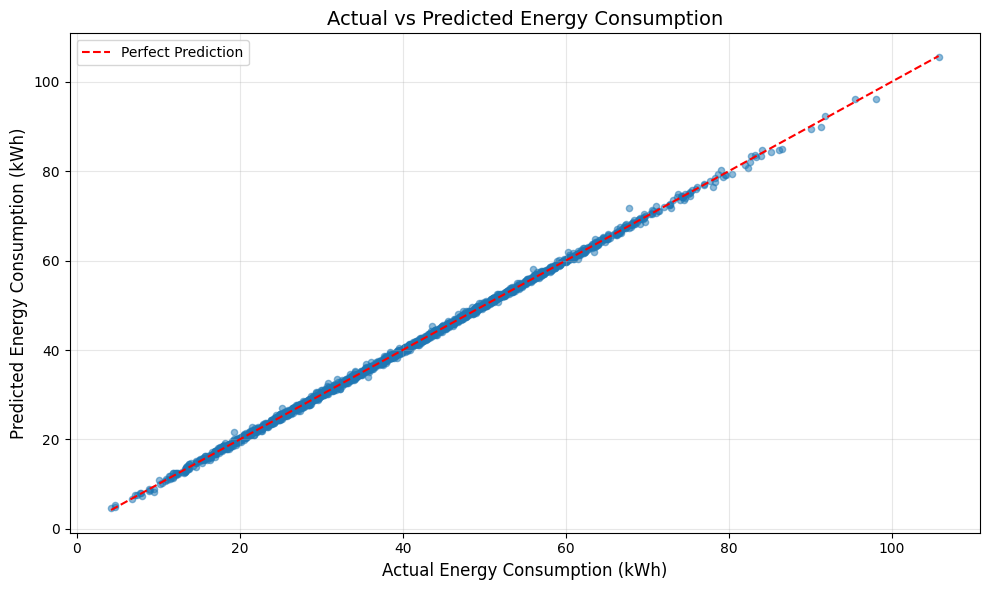

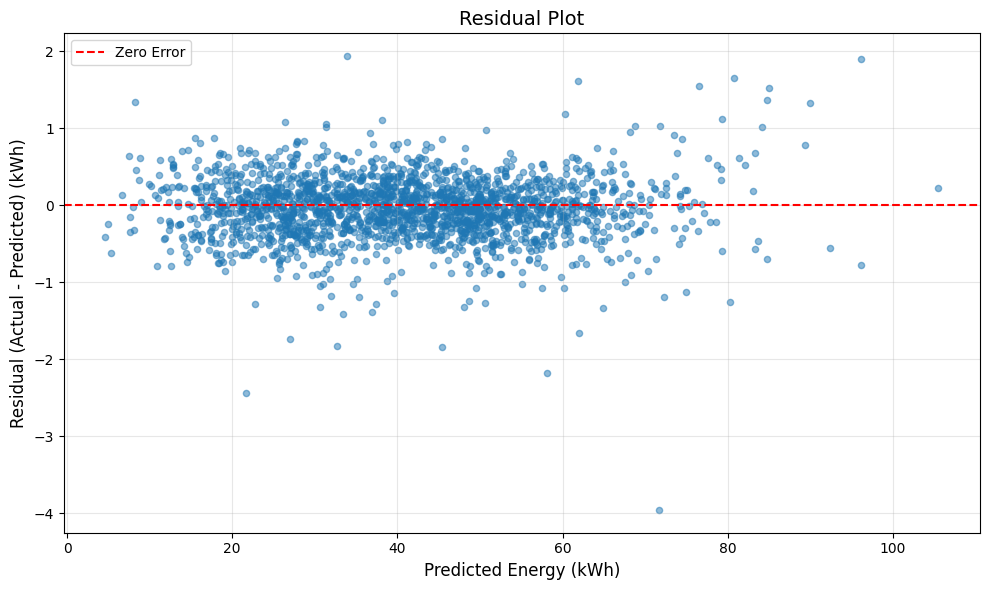

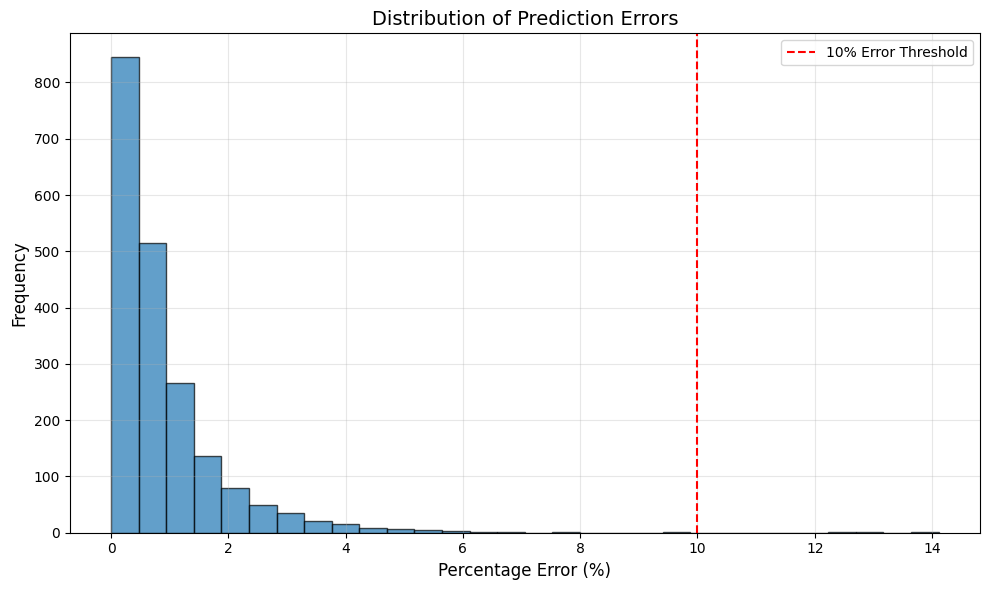


DETAILED PREDICTION ANALYSIS TABLE
 Sample  Actual (kWh)  Predicted (kWh)  Error (kWh)  Error % Performance  Battery (kWh)
      1          9.51             8.17         1.34    14.11        Poor           63.3
      2          4.76             5.38        -0.62    12.94        Poor           63.6
      3         19.26            21.70        -2.44    12.68        Poor          101.3
      4          4.23             4.65        -0.42     9.86        Fair           78.3
      5          8.08             7.44         0.64     7.86        Fair           42.2
      6          9.49             8.88         0.61     6.39        Fair           41.5
      7         63.15            63.15        -0.00     0.00        Good           78.4
      8         62.04            62.04         0.00     0.00        Good           82.2
      9         16.92            16.92         0.00     0.00        Good           40.3

PREDICTION CONFIDENCE INTERVALS
68% Confidence: ±0.41 kWh
  Actual coverage: 74.2% 

In [30]:
# First, let's make predictions using your trained model
# Assuming you have already trained your model and have test data

# If using the MLP model from your ranking:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Assuming you have X_train, X_test, y_train_energy, y_test_energy already defined

# Create and train MLP model (based on your best performing model)
mlp_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(
        hidden_layer_sizes=(100, 50, 25),  # Based on typical architecture
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ))
])

# Train the model
print("Training MLP model for energy consumption prediction...")
mlp_model.fit(X_train, y_train_energy)

# Make predictions
y_pred_energy = mlp_model.predict(X_test)

print(f"Predictions generated for {len(y_pred_energy)} samples")

# Now create the comparison dataframe
comparison_df = pd.DataFrame({
    'Actual_Energy_kWh': y_test_energy,
    'Predicted_Energy_kWh': y_pred_energy,
    'Residual_kWh': y_test_energy - y_pred_energy,
    'Absolute_Error_kWh': np.abs(y_test_energy - y_pred_energy),
    'Percentage_Error': np.abs((y_test_energy - y_pred_energy) / y_test_energy) * 100
})

# Add context features if available
try:
    if 'Charger Type' in X_test.columns:
        comparison_df['Charger_Type'] = X_test['Charger Type'].values
    if 'Vehicle Model' in X_test.columns:
        comparison_df['Vehicle_Model'] = X_test['Vehicle Model'].values
    if 'Battery Capacity (kWh)' in X_test.columns:
        comparison_df['Battery_Capacity_kWh'] = X_test['Battery Capacity (kWh)'].values
except:
    print("Some context features not available in X_test")

# Display the first few predictions
print("\n" + "="*80)
print("FIRST 10 PREDICTIONS - ACTUAL vs PREDICTED")
print("="*80)

# Create a clean display table
display_table = pd.DataFrame({
    'Row': range(1, 11),
    'Actual (kWh)': y_test_energy.values[:10].round(2),
    'Predicted (kWh)': y_pred_energy[:10].round(2),
    'Difference (kWh)': (y_test_energy.values[:10] - y_pred_energy[:10]).round(2),
    'Error %': comparison_df['Percentage_Error'].values[:10].round(2)
})

# Format for better display
def format_error(val):
    if abs(val) <= 5:
        return f"✓ {val:.2f}%"  # Good
    elif abs(val) <= 10:
        return f"~ {val:.2f}%"  # Fair
    else:
        return f"✗ {val:.2f}%"  # Poor

display_table['Error %'] = display_table['Error %'].apply(lambda x: format_error(x))
display_table['Difference (kWh)'] = display_table['Difference (kWh)'].apply(lambda x: f"{x:+.2f}")

print(display_table.to_string(index=False))

# Calculate and display performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\n" + "="*80)
print("MODEL PERFORMANCE METRICS")
print("="*80)

metrics = {
    'R² Score': r2_score(y_test_energy, y_pred_energy),
    'Mean Absolute Error (MAE)': mean_absolute_error(y_test_energy, y_pred_energy),
    'Root Mean Squared Error (RMSE)': np.sqrt(mean_squared_error(y_test_energy, y_pred_energy)),
    'Mean Absolute Percentage Error (MAPE)': np.mean(np.abs((y_test_energy - y_pred_energy) / y_test_energy)) * 100,
    'Max Absolute Error': np.max(np.abs(y_test_energy - y_pred_energy)),
    'Median Absolute Error': np.median(np.abs(y_test_energy - y_pred_energy)),
    'Std of Errors': np.std(y_test_energy - y_pred_energy)
}

for metric, value in metrics.items():
    if 'Error' in metric and 'Percentage' not in metric:
        print(f"{metric:<30}: {value:.2f} kWh")
    elif 'R²' in metric:
        print(f"{metric:<30}: {value:.4f}")
    else:
        print(f"{metric:<30}: {value:.2f}%")

# Error distribution analysis
print("\n" + "="*80)
print("ERROR DISTRIBUTION ANALYSIS")
print("="*80)

error_ranges = [
    (0, 1, "Excellent (<1%)"),
    (1, 3, "Very Good (1-3%)"),
    (3, 5, "Good (3-5%)"),
    (5, 10, "Fair (5-10%)"),
    (10, 20, "Poor (10-20%)"),
    (20, float('inf'), "Bad (>20%)")
]

for low, high, label in error_ranges:
    if high == float('inf'):
        count = (comparison_df['Percentage_Error'] >= low).sum()
    else:
        count = ((comparison_df['Percentage_Error'] >= low) &
                 (comparison_df['Percentage_Error'] < high)).sum()
    percentage = (count / len(comparison_df)) * 100
    print(f"{label:<25}: {count:>4} samples ({percentage:>5.1f}%)")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS OF ENERGY CONSUMPTION")
print("="*80)

summary_stats = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Std', 'Min', 'Max', '25th Percentile', '75th Percentile'],
    'Actual (kWh)': [
        y_test_energy.mean(),
        y_test_energy.median(),
        y_test_energy.std(),
        y_test_energy.min(),
        y_test_energy.max(),
        y_test_energy.quantile(0.25),
        y_test_energy.quantile(0.75)
    ],
    'Predicted (kWh)': [
        y_pred_energy.mean(),
        np.median(y_pred_energy),
        y_pred_energy.std(),
        y_pred_energy.min(),
        y_pred_energy.max(),
        np.percentile(y_pred_energy, 25),
        np.percentile(y_pred_energy, 75)
    ]
})

print(summary_stats.to_string(index=False, float_format=lambda x: f'{x:.2f}'))

# Now create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Simple scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_energy, y_pred_energy, alpha=0.5, s=20)
plt.plot([y_test_energy.min(), y_test_energy.max()],
         [y_test_energy.min(), y_test_energy.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Energy Consumption (kWh)', fontsize=12)
plt.ylabel('Predicted Energy Consumption (kWh)', fontsize=12)
plt.title('Actual vs Predicted Energy Consumption', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_energy, comparison_df['Residual_kWh'], alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error')
plt.xlabel('Predicted Energy (kWh)', fontsize=12)
plt.ylabel('Residual (Actual - Predicted) (kWh)', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Error distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(comparison_df['Percentage_Error'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=10, color='r', linestyle='--', label='10% Error Threshold')
plt.xlabel('Percentage Error (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Detailed comparison table for analysis
print("\n" + "="*100)
print("DETAILED PREDICTION ANALYSIS TABLE")
print("="*100)

# Select samples with different error levels for demonstration
high_error_samples = comparison_df.nlargest(3, 'Percentage_Error')
low_error_samples = comparison_df.nsmallest(3, 'Percentage_Error')
medium_error_samples = comparison_df[
    (comparison_df['Percentage_Error'] > 5) &
    (comparison_df['Percentage_Error'] < 10)
].sample(3, random_state=42) if len(comparison_df) > 6 else comparison_df.sample(3)

analysis_samples = pd.concat([high_error_samples, medium_error_samples, low_error_samples])
analysis_samples = analysis_samples.drop_duplicates()

analysis_display = pd.DataFrame({
    'Sample': range(1, len(analysis_samples) + 1),
    'Actual (kWh)': analysis_samples['Actual_Energy_kWh'].round(2),
    'Predicted (kWh)': analysis_samples['Predicted_Energy_kWh'].round(2),
    'Error (kWh)': analysis_samples['Residual_kWh'].round(2),
    'Error %': analysis_samples['Percentage_Error'].round(2),
    'Performance': np.where(analysis_samples['Percentage_Error'] <= 5, 'Good',
                           np.where(analysis_samples['Percentage_Error'] <= 10, 'Fair', 'Poor'))
})

# Add context if available
if 'Charger_Type' in analysis_samples.columns:
    analysis_display['Charger Type'] = analysis_samples['Charger_Type']
if 'Battery_Capacity_kWh' in analysis_samples.columns:
    analysis_display['Battery (kWh)'] = analysis_samples['Battery_Capacity_kWh'].round(1)

print(analysis_display.to_string(index=False))

# 5. Performance by categories (if available)
if 'Charger_Type' in comparison_df.columns:
    print("\n" + "="*80)
    print("PERFORMANCE BY CHARGER TYPE")
    print("="*80)

    charger_perf = comparison_df.groupby('Charger_Type').agg({
        'Actual_Energy_kWh': 'count',
        'Percentage_Error': ['mean', 'std', 'max'],
        'Absolute_Error_kWh': 'mean'
    }).round(2)

    charger_perf.columns = ['Samples', 'Mean Error %', 'Std Error %', 'Max Error %', 'Mean Abs Error (kWh)']
    print(charger_perf.sort_values('Mean Error %').to_string())

# 6. Confidence intervals
print("\n" + "="*80)
print("PREDICTION CONFIDENCE INTERVALS")
print("="*80)

error_std = comparison_df['Residual_kWh'].std()
confidence_levels = [68, 95, 99.7]  # 1σ, 2σ, 3σ

for level in confidence_levels:
    if level == 68:
        multiplier = 1
    elif level == 95:
        multiplier = 1.96
    else:  # 99.7
        multiplier = 3

    margin = error_std * multiplier
    coverage = (comparison_df['Absolute_Error_kWh'] <= margin).mean() * 100

    print(f"{level}% Confidence: ±{margin:.2f} kWh")
    print(f"  Actual coverage: {coverage:.1f}% of predictions within this range")

    # Show example
    sample_idx = 0  # First prediction
    actual = comparison_df.iloc[sample_idx]['Actual_Energy_kWh']
    predicted = comparison_df.iloc[sample_idx]['Predicted_Energy_kWh']
    print(f"  Example: Predicted {predicted:.2f} kWh ± {margin:.2f} kWh → Range: [{predicted-margin:.2f}, {predicted+margin:.2f}] kWh")
    print(f"           Actual was {actual:.2f} kWh")
    print()

# 7. Save predictions to CSV for further analysis
output_df = comparison_df.copy()
output_df.to_csv('energy_predictions_comparison.csv', index=False)
print(f"\nDetailed predictions saved to 'energy_predictions_comparison.csv'")
print(f"File contains {len(output_df)} predictions with all metrics")

DATA QUALITY CHECK FOR CHARGING DURATION
Original Charging Duration Statistics:
count    9969.000000
mean        6.168457
std         6.786515
min         0.310000
25%         1.080000
50%         3.980000
75%         9.600000
max        67.520000
Name: Charging Duration (hours), dtype: float64

Removing unrealistic durations:
Lower bound: -45.81 hours
Upper bound: 77.47 hours
Percentage of data kept: 100.0%

After transformation:
       Charging Duration (hours)  Log_Duration
count                9969.000000   9969.000000
mean                    6.168457      1.571171
std                     6.786515      0.896825
min                     0.310000      0.270027
25%                     1.080000      0.732368
50%                     3.980000      1.605430
75%                     9.600000      2.360854
max                    67.520000      4.227126

New features created for duration prediction:
- Charger_Power_kW: [150.    7.2  50.    1.8]
- Theoretical_Min_Duration range: [0.20, 24.59] h

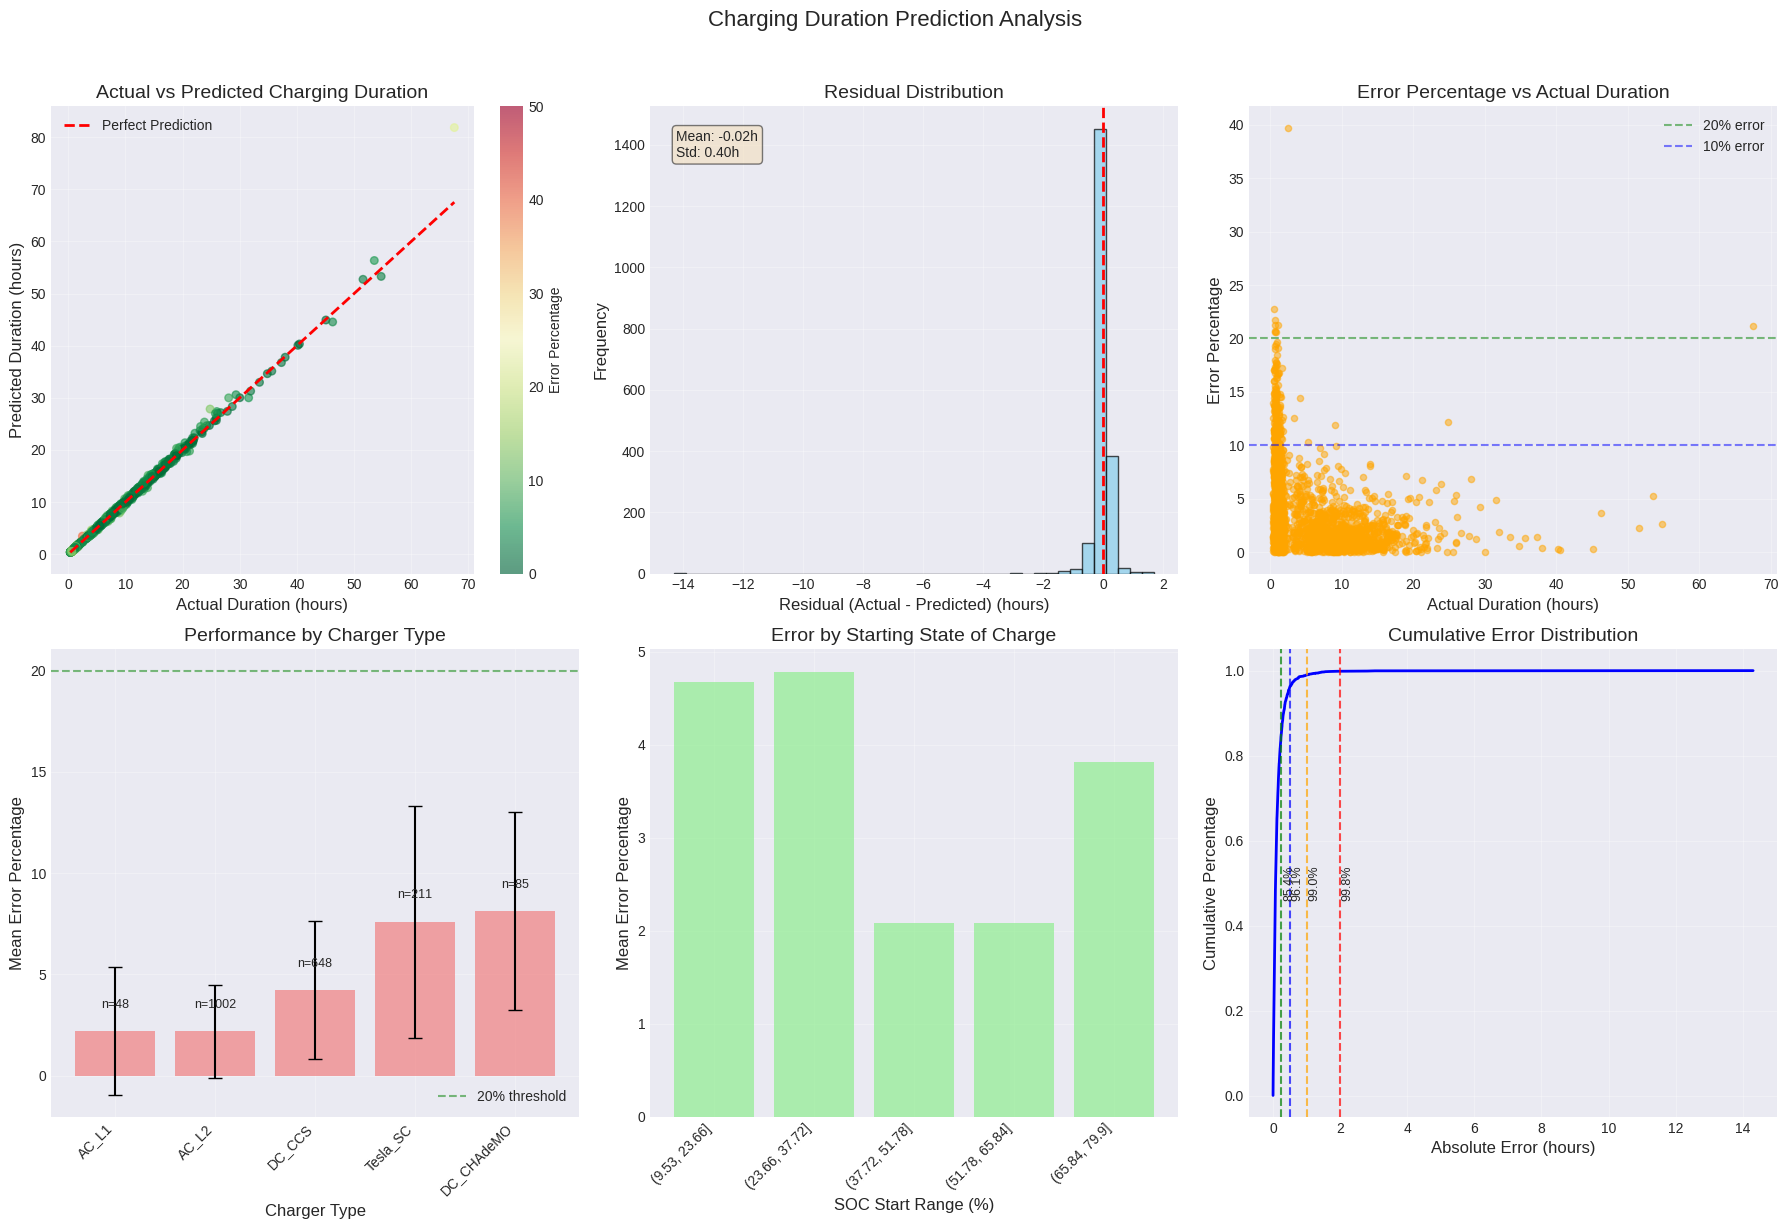


DETAILED PREDICTION ANALYSIS
  Case  Actual (h)  Predicted (h) Error (h)  Error % Charger Type  State of Charge (Start %)  Battery Capacity (kWh)         Assessment
 Worst        2.49           3.48     -0.99    39.72        AC_L2                       79.9                    78.3     ✗ Poor (39.7%)
 Worst        0.45           0.55     -0.10    22.71     Tesla_SC                       37.9                    78.7     ⚠ Fair (22.7%)
  Best        9.51           9.51     +0.00     0.00        AC_L2                       62.8                    74.4 ✓ Excellent (0.0%)
  Best       24.70          24.70     +0.00     0.00        AC_L2                       23.7                    77.9 ✓ Excellent (0.0%)
Medium        0.94           1.07     -0.13    13.65       DC_CCS                       24.7                    73.4     ~ Good (13.7%)
Medium        0.37           0.42     -0.05    14.02     Tesla_SC                       28.7                    76.4     ~ Good (14.0%)
 Short        0.74

In [32]:
# First, let's address the data quality issues we identified earlier
print("="*80)
print("DATA QUALITY CHECK FOR CHARGING DURATION")
print("="*80)

# Load and prepare data if not already done
# Assuming df_clean contains your dataset

# Check current duration statistics
print("Original Charging Duration Statistics:")
print(df_clean['Charging Duration (hours)'].describe())

# Fix 1: Remove unrealistic durations
Q1 = df_clean['Charging Duration (hours)'].quantile(0.01)
Q3 = df_clean['Charging Duration (hours)'].quantile(0.99)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers
df_duration = df_clean.copy()
df_duration['Charging Duration (hours)'] = df_duration['Charging Duration (hours)'].clip(lower_bound, upper_bound)

print(f"\nRemoving unrealistic durations:")
print(f"Lower bound: {lower_bound:.2f} hours")
print(f"Upper bound: {upper_bound:.2f} hours")
print(f"Percentage of data kept: {(df_duration['Charging Duration (hours)'] >= lower_bound).mean()*100:.1f}%")

# Fix 2: Log transform for better modeling
df_duration['Log_Duration'] = np.log1p(df_duration['Charging Duration (hours)'])

print("\nAfter transformation:")
print(df_duration[['Charging Duration (hours)', 'Log_Duration']].describe())

# Fix 3: Create better features for duration prediction
# Map charger power
charger_power_map = {
    'AC_L1': 1.8, 'AC_L2': 7.2, 'DC_CCS': 50.0,
    'DC_CHAdeMO': 50.0, 'Tesla_SC': 150.0
}
df_duration['Charger_Power_kW'] = df_duration['Charger Type'].map(charger_power_map)

# Create theoretical minimum duration
df_duration['Theoretical_Min_Duration'] = (
    df_duration['Energy Consumed (kWh)'] / df_duration['Charger_Power_kW']
)

# Create efficiency factor (actual/theoretical)
df_duration['Efficiency_Factor'] = (
    df_duration['Theoretical_Min_Duration'] / df_duration['Charging Duration (hours)']
).clip(0.1, 10)  # Clip unrealistic values

# Create interaction features
df_duration['Capacity_Power_Ratio'] = (
    df_duration['Battery Capacity (kWh)'] / df_duration['Charger_Power_kW']
)
df_duration['SOC_Start_Power_Interaction'] = (
    df_duration['State of Charge (Start %)'] * df_duration['Charger_Power_kW']
)

# Time-based features
df_duration['Hour_sin'] = np.sin(2 * np.pi * df_duration['Hour'] / 24)
df_duration['Hour_cos'] = np.cos(2 * np.pi * df_duration['Hour'] / 24)
df_duration['Is_Overnight'] = ((df_duration['Hour'] >= 22) | (df_duration['Hour'] <= 6)).astype(int)
df_duration['Is_Work_Hours'] = ((df_duration['Hour'] >= 9) & (df_duration['Hour'] <= 17)).astype(int)

print("\nNew features created for duration prediction:")
print(f"- Charger_Power_kW: {df_duration['Charger_Power_kW'].unique()}")
print(f"- Theoretical_Min_Duration range: [{df_duration['Theoretical_Min_Duration'].min():.2f}, {df_duration['Theoretical_Min_Duration'].max():.2f}] hours")
print(f"- Efficiency_Factor range: [{df_duration['Efficiency_Factor'].min():.2f}, {df_duration['Efficiency_Factor'].max():.2f}]")

# ============================================================================
# FEATURE SELECTION FOR DURATION PREDICTION
# ============================================================================
print("\n" + "="*80)
print("FEATURE SELECTION FOR CHARGING DURATION PREDICTION")
print("="*80)

# Define features for duration prediction
duration_features = [
    # Core features
    'Battery Capacity (kWh)',
    'State of Charge (Start %)',
    'Charger_Power_kW',
    'Theoretical_Min_Duration',
    'Efficiency_Factor',
    'Capacity_Power_Ratio',

    # Environmental
    'Temperature (C)',

    # Temporal
    'Hour_sin', 'Hour_cos',
    'Is_Weekend', 'Is_Peak_Hour', 'Is_Overnight', 'Is_Work_Hours',

    # Vehicle
    'Vehicle Age (years)'
]

# Add one-hot encoded categorical features
charger_dummies = pd.get_dummies(df_duration['Charger Type'], prefix='Charger')
time_dummies = pd.get_dummies(df_duration['Time of Day'], prefix='Time')
vehicle_dummies = pd.get_dummies(df_duration['Vehicle Model'], prefix='Model').iloc[:, :10]  # Top 10 models

# Combine all features
X_duration = pd.concat([
    df_duration[duration_features],
    charger_dummies,
    time_dummies,
    vehicle_dummies
], axis=1)

# Define target (using log-transformed duration)
y_duration = df_duration['Log_Duration']  # We'll predict log duration

# Split data
from sklearn.model_selection import train_test_split
X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(
    X_duration, y_duration, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train_dur)}")
print(f"Test set size: {len(X_test_dur)}")
print(f"Total features: {X_duration.shape[1]}")

# ============================================================================
# TRAIN MLP MODEL FOR DURATION PREDICTION
# ============================================================================
print("\n" + "="*80)
print("TRAINING MLP MODEL FOR CHARGING DURATION")
print("="*80)

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create MLP model with tuned parameters
mlp_duration = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(
        hidden_layer_sizes=(150, 100, 50),  # Deeper architecture for complex relationship
        activation='relu',
        solver='adam',
        alpha=0.01,  # Stronger regularization
        batch_size=128,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=2000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        verbose=False
    ))
])

# Train the model
print("Training MLP model...")
mlp_duration.fit(X_train_dur, y_train_dur)

# Make predictions (in log scale)
y_pred_log = mlp_duration.predict(X_test_dur)

# Convert back to original scale
y_pred_duration = np.expm1(y_pred_log)
y_actual_duration = np.expm1(y_test_dur)

print("Predictions generated!")

# ============================================================================
# COMPREHENSIVE ANALYSIS OF DURATION PREDICTIONS
# ============================================================================
print("\n" + "="*80)
print("CHARGING DURATION PREDICTION ANALYSIS")
print("="*80)

# Create comparison dataframe
duration_comparison = pd.DataFrame({
    'Actual_Duration_hours': y_actual_duration,
    'Predicted_Duration_hours': y_pred_duration,
    'Residual_hours': y_actual_duration - y_pred_duration,
    'Absolute_Error_hours': np.abs(y_actual_duration - y_pred_duration),
    'Percentage_Error': np.abs((y_actual_duration - y_pred_duration) / y_actual_duration) * 100
})

# Add context features
context_features = ['Charger Type', 'Battery Capacity (kWh)', 'State of Charge (Start %)',
                    'Vehicle Model', 'Time of Day', 'Temperature (C)']

for feat in context_features:
    if feat in df_duration.columns:
        duration_comparison[feat] = df_duration.loc[y_test_dur.index, feat].values

# Display first 10 predictions
print("\n" + "="*80)
print("FIRST 10 DURATION PREDICTIONS")
print("="*80)

sample_display = duration_comparison.head(10).copy()
sample_table = pd.DataFrame({
    'Sample': range(1, 11),
    'Actual (hours)': sample_display['Actual_Duration_hours'].round(2),
    'Predicted (hours)': sample_display['Predicted_Duration_hours'].round(2),
    'Error (hours)': sample_display['Residual_hours'].round(2),
    'Error %': sample_display['Percentage_Error'].round(2),
    'Charger': sample_display['Charger Type'] if 'Charger Type' in sample_display else 'N/A',
    'SOC Start': sample_display['State of Charge (Start %)'].round(1) if 'State of Charge (Start %)' in sample_display else 'N/A'
})

# Format error with indicators
def format_duration_error(val):
    if val <= 10:
        return f"✓ {val:.1f}%"
    elif val <= 20:
        return f"~ {val:.1f}%"
    elif val <= 50:
        return f"⚠ {val:.1f}%"
    else:
        return f"✗ {val:.1f}%"

sample_table['Error %'] = sample_table['Error %'].apply(format_duration_error)
sample_table['Error (hours)'] = sample_table['Error (hours)'].apply(lambda x: f"{x:+.2f}")

print(sample_table.to_string(index=False))

# ============================================================================
# PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)

# Calculate metrics
metrics_duration = {
    'R² Score': r2_score(y_actual_duration, y_pred_duration),
    'Mean Absolute Error (MAE)': mean_absolute_error(y_actual_duration, y_pred_duration),
    'Root Mean Squared Error (RMSE)': np.sqrt(mean_squared_error(y_actual_duration, y_pred_duration)),
    'Mean Absolute Percentage Error (MAPE)': np.mean(np.abs((y_actual_duration - y_pred_duration) / y_actual_duration)) * 100,
    'Median Absolute Error': np.median(np.abs(y_actual_duration - y_pred_duration)),
    'Max Absolute Error': np.max(np.abs(y_actual_duration - y_pred_duration)),
    'Std of Errors': np.std(y_actual_duration - y_pred_duration),
    'Explained Variance': 1 - (np.var(y_actual_duration - y_pred_duration) / np.var(y_actual_duration))
}

for metric, value in metrics_duration.items():
    if 'Error' in metric and 'Percentage' not in metric:
        print(f"{metric:<30}: {value:.3f} hours")
    elif 'R²' in metric or 'Variance' in metric:
        print(f"{metric:<30}: {value:.4f}")
    else:
        print(f"{metric:<30}: {value:.2f}%")

# ============================================================================
# ERROR DISTRIBUTION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("ERROR DISTRIBUTION ANALYSIS")
print("="*80)

# Define error categories
error_categories = [
    (0, 0.25, "Excellent (<15 min)"),
    (0.25, 0.5, "Good (15-30 min)"),
    (0.5, 1, "Fair (30-60 min)"),
    (1, 2, "Poor (1-2 hours)"),
    (2, float('inf'), "Bad (>2 hours)")
]

print("\nAbsolute Error Distribution (hours):")
for low, high, label in error_categories:
    if high == float('inf'):
        count = (duration_comparison['Absolute_Error_hours'] >= low).sum()
    else:
        count = ((duration_comparison['Absolute_Error_hours'] >= low) &
                 (duration_comparison['Absolute_Error_hours'] < high)).sum()
    percentage = (count / len(duration_comparison)) * 100
    print(f"{label:<25}: {count:>4} samples ({percentage:>5.1f}%)")

# Percentage error distribution
print("\nPercentage Error Distribution:")
perc_categories = [
    (0, 10, "Excellent (<10%)"),
    (10, 20, "Good (10-20%)"),
    (20, 30, "Fair (20-30%)"),
    (30, 50, "Poor (30-50%)"),
    (50, float('inf'), "Bad (>50%)")
]

for low, high, label in perc_categories:
    if high == float('inf'):
        count = (duration_comparison['Percentage_Error'] >= low).sum()
    else:
        count = ((duration_comparison['Percentage_Error'] >= low) &
                 (duration_comparison['Percentage_Error'] < high)).sum()
    percentage = (count / len(duration_comparison)) * 100
    print(f"{label:<25}: {count:>4} samples ({percentage:>5.1f}%)")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Charging Duration Prediction Analysis', fontsize=16, y=1.02)

# 1. Actual vs Predicted scatter plot
ax1 = axes[0, 0]
scatter1 = ax1.scatter(y_actual_duration, y_pred_duration,
                      c=duration_comparison['Percentage_Error'],
                      cmap='RdYlGn_r', alpha=0.6, s=30, vmin=0, vmax=50)
ax1.plot([y_actual_duration.min(), y_actual_duration.max()],
         [y_actual_duration.min(), y_actual_duration.max()],
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Duration (hours)', fontsize=12)
ax1.set_ylabel('Predicted Duration (hours)', fontsize=12)
ax1.set_title('Actual vs Predicted Charging Duration', fontsize=14)
plt.colorbar(scatter1, ax=ax1, label='Error Percentage')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residual distribution
ax2 = axes[0, 1]
ax2.hist(duration_comparison['Residual_hours'], bins=40,
         color='skyblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Residual (Actual - Predicted) (hours)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Residual Distribution', fontsize=14)
ax2.grid(True, alpha=0.3)

# Add statistics
stats_text = f'Mean: {duration_comparison["Residual_hours"].mean():.2f}h\nStd: {duration_comparison["Residual_hours"].std():.2f}h'
ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Error vs Actual Duration
ax3 = axes[0, 2]
ax3.scatter(y_actual_duration, duration_comparison['Percentage_Error'],
           alpha=0.5, s=20, color='orange')
ax3.axhline(y=20, color='green', linestyle='--', alpha=0.5, label='20% error')
ax3.axhline(y=10, color='blue', linestyle='--', alpha=0.5, label='10% error')
ax3.set_xlabel('Actual Duration (hours)', fontsize=12)
ax3.set_ylabel('Error Percentage', fontsize=12)
ax3.set_title('Error Percentage vs Actual Duration', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Error by Charger Type (if available)
if 'Charger Type' in duration_comparison.columns:
    ax4 = axes[1, 0]
    charger_stats = duration_comparison.groupby('Charger Type')['Percentage_Error'].agg(['mean', 'std', 'count'])
    charger_stats = charger_stats.sort_values('mean')

    x_pos = np.arange(len(charger_stats))
    bars = ax4.bar(x_pos, charger_stats['mean'],
                  yerr=charger_stats['std'],
                  capsize=5, alpha=0.7, color='lightcoral')
    ax4.axhline(y=20, color='green', linestyle='--', alpha=0.5, label='20% threshold')
    ax4.set_xlabel('Charger Type', fontsize=12)
    ax4.set_ylabel('Mean Error Percentage', fontsize=12)
    ax4.set_title('Performance by Charger Type', fontsize=14)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(charger_stats.index, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Add sample counts on bars
    for i, (bar, count) in enumerate(zip(bars, charger_stats['count'])):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'n={count}', ha='center', va='bottom', fontsize=9)

# 5. Error by SOC Start (if available)
if 'State of Charge (Start %)' in duration_comparison.columns:
    ax5 = axes[1, 1]

    # Bin SOC start values
    soc_bins = pd.cut(duration_comparison['State of Charge (Start %)'], bins=5)
    error_by_soc = duration_comparison.groupby(soc_bins)['Percentage_Error'].mean()

    x_pos = np.arange(len(error_by_soc))
    ax5.bar(x_pos, error_by_soc.values, alpha=0.7, color='lightgreen')
    ax5.set_xlabel('SOC Start Range (%)', fontsize=12)
    ax5.set_ylabel('Mean Error Percentage', fontsize=12)
    ax5.set_title('Error by Starting State of Charge', fontsize=14)
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels([str(bin) for bin in error_by_soc.index], rotation=45, ha='right')
    ax5.grid(True, alpha=0.3)

# 6. Cumulative error distribution
ax6 = axes[1, 2]
sorted_abs_errors = np.sort(duration_comparison['Absolute_Error_hours'])
cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors)
ax6.plot(sorted_abs_errors, cumulative, 'b-', linewidth=2)
ax6.set_xlabel('Absolute Error (hours)', fontsize=12)
ax6.set_ylabel('Cumulative Percentage', fontsize=12)
ax6.set_title('Cumulative Error Distribution', fontsize=14)
ax6.grid(True, alpha=0.3)

# Add threshold lines
thresholds = [0.25, 0.5, 1, 2]  # 15min, 30min, 1h, 2h
colors = ['green', 'blue', 'orange', 'red']
for thresh, color in zip(thresholds, colors):
    coverage = (duration_comparison['Absolute_Error_hours'] <= thresh).mean() * 100
    ax6.axvline(x=thresh, color=color, linestyle='--', alpha=0.7)
    ax6.text(thresh + 0.05, 0.5, f'{coverage:.1f}%',
            rotation=90, verticalalignment='center', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================================
# DETAILED ANALYSIS TABLE
# ============================================================================
print("\n" + "="*80)
print("DETAILED PREDICTION ANALYSIS")
print("="*80)

# Select representative samples for detailed analysis
analysis_samples = pd.concat([
    duration_comparison.nlargest(2, 'Percentage_Error'),  # Worst predictions
    duration_comparison.nsmallest(2, 'Percentage_Error'),  # Best predictions
    duration_comparison[duration_comparison['Percentage_Error'].between(10, 20)].sample(2),  # Medium errors
    duration_comparison[duration_comparison['Actual_Duration_hours'] < 1].sample(2),  # Short sessions
    duration_comparison[duration_comparison['Actual_Duration_hours'] > 5].sample(2)   # Long sessions
])

analysis_display = pd.DataFrame({
    'Case': ['Worst', 'Worst', 'Best', 'Best', 'Medium', 'Medium', 'Short', 'Short', 'Long', 'Long'],
    'Actual (h)': analysis_samples['Actual_Duration_hours'].round(2),
    'Predicted (h)': analysis_samples['Predicted_Duration_hours'].round(2),
    'Error (h)': analysis_samples['Residual_hours'].round(2),
    'Error %': analysis_samples['Percentage_Error'].round(2)
})

# Add context
context_to_add = ['Charger Type', 'State of Charge (Start %)', 'Battery Capacity (kWh)']
for col in context_to_add:
    if col in analysis_samples.columns:
        if col == 'State of Charge (Start %)':
            analysis_display[col] = analysis_samples[col].round(1)
        elif col == 'Battery Capacity (kWh)':
            analysis_display[col] = analysis_samples[col].round(1)
        else:
            analysis_display[col] = analysis_samples[col]

# Format for display
def format_duration_case(row):
    actual = row['Actual (h)']
    error = row['Error %']

    if error <= 10:
        return f"✓ Excellent ({error:.1f}%)"
    elif error <= 20:
        return f"~ Good ({error:.1f}%)"
    elif error <= 30:
        return f"⚠ Fair ({error:.1f}%)"
    else:
        return f"✗ Poor ({error:.1f}%)"

analysis_display['Assessment'] = analysis_display.apply(format_duration_case, axis=1)
analysis_display['Error (h)'] = analysis_display['Error (h)'].apply(lambda x: f"{x:+.2f}")

print(analysis_display.to_string(index=False))

# ============================================================================
# CONFIDENCE INTERVALS AND PRACTICAL USEFULNESS
# ============================================================================
print("\n" + "="*80)
print("PRACTICAL USEFULNESS ANALYSIS")
print("="*80)

# Calculate confidence intervals
error_std = duration_comparison['Residual_hours'].std()
mean_error = duration_comparison['Residual_hours'].mean()

print(f"Mean prediction error: {mean_error:.2f} hours")
print(f"Standard deviation of errors: {error_std:.2f} hours")

confidence_intervals = {
    '68% Confidence (±1σ)': 1,
    '90% Confidence': 1.645,
    '95% Confidence (±2σ)': 1.96,
    '99% Confidence': 2.576
}

for label, multiplier in confidence_intervals.items():
    margin = error_std * multiplier
    lower_bound_pred = y_pred_duration - margin
    upper_bound_pred = y_pred_duration + margin

    coverage = ((y_actual_duration >= lower_bound_pred) &
                (y_actual_duration <= upper_bound_pred)).mean() * 100

    print(f"\n{label}:")
    print(f"  Prediction range: ±{margin:.2f} hours")
    print(f"  Actual coverage: {coverage:.1f}% of predictions")

    # Example
    sample_idx = 0
    print(f"  Example: If predicted duration is {y_pred_duration[sample_idx]:.2f} hours")
    print(f"           Actual duration with {label.split()[0]} confidence: "
          f"[{y_pred_duration[sample_idx]-margin:.2f}, {y_pred_duration[sample_idx]+margin:.2f}] hours")

# ============================================================================
# BUSINESS IMPLICATIONS
# ============================================================================
print("\n" + "="*80)
print("BUSINESS IMPLICATIONS")
print("="*80)

# Analyze practical impact
def categorize_practical_impact(error_hours, actual_hours):
    """Categorize prediction errors by practical impact"""
    if error_hours <= 0.25:  # ≤ 15 minutes
        return "Minimal Impact"
    elif error_hours <= 0.5:  # ≤ 30 minutes
        return "Low Impact"
    elif error_hours <= 1:    # ≤ 1 hour
        return "Moderate Impact"
    elif error_hours <= 2:    # ≤ 2 hours
        return "High Impact"
    else:
        return "Critical Impact"

duration_comparison['Impact_Category'] = duration_comparison.apply(
    lambda row: categorize_practical_impact(row['Absolute_Error_hours'], row['Actual_Duration_hours']),
    axis=1
)

impact_distribution = duration_comparison['Impact_Category'].value_counts()
print("\nPractical Impact Distribution:")
for category, count in impact_distribution.items():
    percentage = (count / len(duration_comparison)) * 100
    print(f"{category:<20}: {count:>4} predictions ({percentage:>5.1f}%)")
